# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output  # draw progress bar

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans  # KMeans

from sklearn.model_selection import StratifiedShuffleSplit  # StratifiedShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostRegressor  # Adaptive Boosting
from xgboost.sklearn import XGBRegressor  # Extreme Gradient Boosting
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
N_JOBS = -1 # Number of parallel threads used to run xgboost and KMeans

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### What we want to do here ...
In this section, we will firet explore `Udacity_AZDIAS_052018.csv`, `Udacity_CUSTOMERS_052018.csv`, `DIAS Information Levels - Attributes 2017.xlsx`, and `DIAS Attributes - Values 2017.xlsx`. Analyze ther relationship and summarize feature type, including binary categorical, nominal categorical, ordinal categorical, mixed categorical, or quantitative. Finally, in the last section. We will try to make a `clean_data` function for data cleaning.

* Data Exploration - general population vs. customers
    - Analyze `Udacity_AZDIAS_052018.csv` and `Udacity_CUSTOMERS_052018.csv`.
* Data Exploration - attributes vs. values
    - Analyze `DIAS Information Levels - Attributes 2017.xlsx`, `DIAS Attributes - Values 2017.xlsx` and create feature types.
* Data Exploration - customers vs. values
    - Analyze feature difference between `Udacity_CUSTOMERS_052018.csv` and `DIAS Attributes - Values 2017.xlsx`.
* Data Exploration - general population vs. customers (2nd)
    - Analyze feature difference between `Udacity_AZDIAS_052018.csv` and `Udacity_CUSTOMERS_052018.csv`
* Data Preprocessing
    - Create a `clean_data` function for data cleaning.

### Data Exploration - general population vs. customers
Analyze `Udacity_AZDIAS_052018.csv` and `Udacity_CUSTOMERS_052018.csv`.

#### Load general population and customers dataset

In [3]:
# load in the data
# general population dataset
azdias_df = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

# customers dataset
customers_df = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/home/fc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [7]:
customers_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


`azdias_df` and `customers_df` have 366 common features, which is the same as `azdias_df` features.

In [8]:
np.intersect1d(azdias_df.columns.values, customers_df.columns.values).shape

(366,)

create `only_attr_customers` to hold `customer_df` only features

In [9]:
only_attr_customers = np.setdiff1d(customers_df.columns.values, azdias_df.columns.values)

CUSTOMER_GROUP distribution

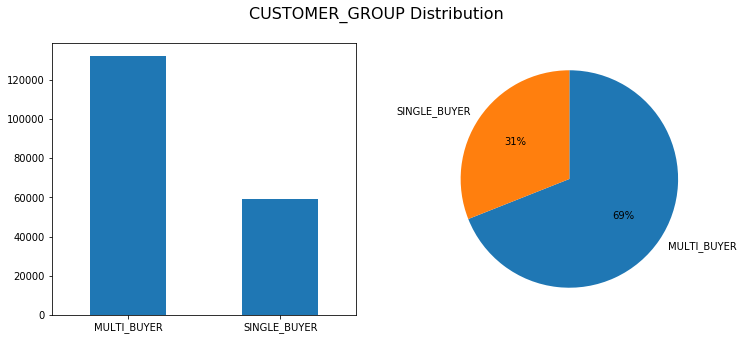

In [10]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.CUSTOMER_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.CUSTOMER_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('CUSTOMER_GROUP Distribution', fontsize=16)
plt.show()

ONLINE_PURCHASE distribution

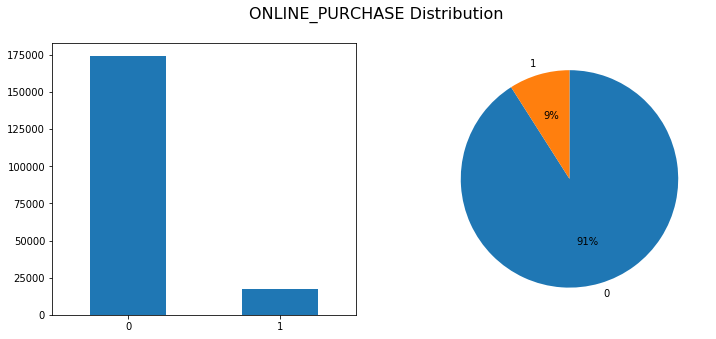

In [11]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.ONLINE_PURCHASE.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.ONLINE_PURCHASE.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('ONLINE_PURCHASE Distribution', fontsize=16)
plt.show()

__NOTE__: customers don't like online purchase.

PRODUCT_GROUP distribution

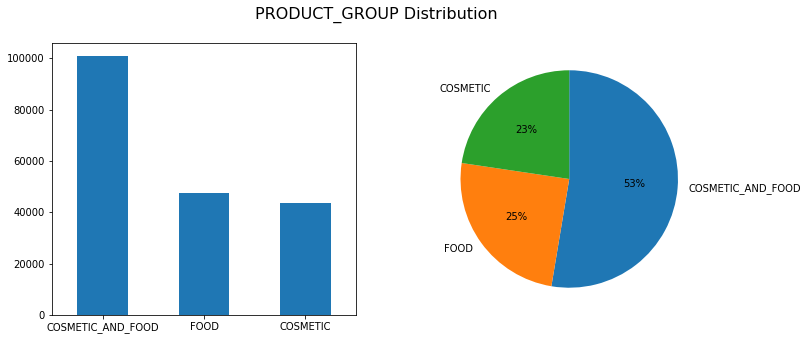

In [12]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.PRODUCT_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.PRODUCT_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('PRODUCT_GROUP Distribution', fontsize=16)
plt.show()

### Data Exploration - attributes vs. values
Analyze `DIAS Information Levels - Attributes 2017.xlsx`, `DIAS Attributes - Values 2017.xlsx` and create feature types.

#### Load attributes dataset

In [13]:
# attributes dataset
attributes_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, index_col=[1]).reset_index()
del attributes_df['Unnamed: 0']
attributes_df.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [14]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
Information level    312 non-null object
Attribute            313 non-null object
Description          313 non-null object
Additional notes     20 non-null object
dtypes: object(4)
memory usage: 9.9+ KB


#### Load values dataset

In [15]:
# values dataset
values_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, index_col=[1,2]).reset_index()
del values_df['Unnamed: 0']
values_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [16]:
values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
Attribute      2258 non-null object
Description    2258 non-null object
Value          2258 non-null object
Meaning        2247 non-null object
dtypes: object(4)
memory usage: 70.6+ KB


In [17]:
# values_df only
np.setdiff1d(values_df.Attribute.unique(), attributes_df.Attribute)

array(['BIP_FLAG', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_LOTTO_RZ',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'KBA13_CCM_3000', 'KBA13_CCM_3001'], dtype=object)

In [18]:
# attributes_df only
np.setdiff1d(attributes_df.Attribute, values_df.Attribute.unique())

array(['ARBEIT', 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
       'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
       'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
       'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
       'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
      dtype=object)

From above, we can find attributes dataset features not normalized. We will use values dataset to query data, and merge attributes dataset feature to values.

Create `attr_only_attributes_not_values` to hold features only in `attributes_df` and not in `values_df`.

In [19]:
attr_only_attributes_not_values = np.array(['ARBEIT', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'])

creqte `annot_attribute` as combined features from `vlaues_df` and `attributes_df`.

In [20]:
annot_attribute = np.union1d(values_df.Attribute.unique(), attr_only_attributes_not_values)

In [21]:
annot_attribute.size

322

We found `only_attr_customers` not in `annot_attribute`

In [22]:
np.isin(only_attr_customers, values_df.Attribute)

array([False, False, False])

#### Analyze feature type

After analyze 'DIAS Information Levels - Attributes 2017.xls' and 'DIAS Attributes - Values 2017.xlsx', xWe create below variable to hold different type of features.

| variable                   | feature type     |
|----------------------------|------------------|
| `bin_cat_annot_attribute`  | binary categor   |
| `nom_cat_annot_attribute`  | nominal category |
| `ord_cat_annot_attribute`  | ordinal category |
| `mix_cat_annot_attribute`  | mix caztegory    |
| `num_annot_attribute`      | quantitative     |
| `unused_annot_attribute`   | unused           |

In [23]:
bin_cat_annot_attribute = np.array(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP'])

nom_cat_annot_attribute = np.array(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ',
       'ZABEOTYP', 'AGER_TYP', 'D19_KONSUMTYP', 'HEALTH_TYP'])

ord_cat_annot_attribute = np.array(['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ARBEIT',
       'BALLRAUM', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12',
       'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'EWDICHTE', 'FINANZ_ANLEGER',
       'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP_RASTER',
       'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1',
       'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2',
       'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU',
       'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3',
       'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP',
       'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2',
       'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER',
       'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2',
       'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST',
       'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2',
       'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MODTEMP',
       'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10',
       'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5',
       'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9',
       'KBA05_VORB0', 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_ZUL1',
       'KBA05_ZUL2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'KBA13_ALTERHALTER_30',
       'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60',
       'KBA13_ALTERHALTER_61', 'KBA13_AUDI', 'KBA13_AUTOQUOTE',
       'KBA13_BJ_1999', 'KBA13_BJ_2000', 'KBA13_BJ_2004', 'KBA13_BJ_2006',
       'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_BMW', 'KBA13_CCM_0_1400',
       'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400',
       'KBA13_CCM_1500', 'KBA13_CCM_1600', 'KBA13_CCM_1800',
       'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501',
       'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FAB_ASIEN',
       'KBA13_FAB_SONSTIGE', 'KBA13_FIAT', 'KBA13_FORD',
       'KBA13_HALTER_20', 'KBA13_HALTER_25', 'KBA13_HALTER_30',
       'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45',
       'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60',
       'KBA13_HALTER_65', 'KBA13_HALTER_66', 'KBA13_HERST_ASIEN',
       'KBA13_HERST_AUDI_VW', 'KBA13_HERST_BMW_BENZ',
       'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL', 'KBA13_HERST_SONST',
       'KBA13_KMH_0_140', 'KBA13_KMH_110', 'KBA13_KMH_140',
       'KBA13_KMH_140_210', 'KBA13_KMH_180', 'KBA13_KMH_211',
       'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KRSAQUOT',
       'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ',
       'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KRSSEG_KLEIN',
       'KBA13_KRSSEG_OBER', 'KBA13_KRSSEG_VAN', 'KBA13_KRSZUL_NEU',
       'KBA13_KW_0_60', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121',
       'KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60',
       'KBA13_KW_61_120', 'KBA13_KW_70', 'KBA13_KW_80', 'KBA13_KW_90',
       'KBA13_MAZDA', 'KBA13_MERCEDES', 'KBA13_MOTOR', 'KBA13_NISSAN',
       'KBA13_OPEL', 'KBA13_PEUGEOT', 'KBA13_RENAULT',
       'KBA13_SEG_GELAENDEWAGEN', 'KBA13_SEG_GROSSRAUMVANS',
       'KBA13_SEG_KLEINST', 'KBA13_SEG_KLEINWAGEN',
       'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_MINIVANS',
       'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_MITTELKLASSE',
       'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_SEG_OBERKLASSE',
       'KBA13_SEG_SONSTIGE', 'KBA13_SEG_SPORTWAGEN',
       'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', 'KBA13_SEG_WOHNMOBILE',
       'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA',
       'KBA13_VORB_0', 'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2',
       'KBA13_VORB_3', 'KBA13_VW', 'KKK', 'KONSUMNAEHE', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'ORTSGR_KLS9',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4',
       'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'REGIOTYP', 'RELAT_AB',
       'RETOURTYP_BK_S', 'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_FAM',
       'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST',
       'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL',
       'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', 'WOHNDAUER_2008',
       'W_KEIT_KIND_HH'])

mix_cat_annot_attribute = np.array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'])

num_annot_attribute = np.array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'])

In [24]:
num_annot_attribute.size + bin_cat_annot_attribute.size + nom_cat_annot_attribute.size + ord_cat_annot_attribute.size + mix_cat_annot_attribute.size

276

In [25]:
unused_annot_attribute = np.setdiff1d(annot_attribute, np.union1d(np.union1d(np.union1d(np.union1d(num_annot_attribute, bin_cat_annot_attribute), nom_cat_annot_attribute), ord_cat_annot_attribute), mix_cat_annot_attribute))

In [26]:
assert annot_attribute.size == num_annot_attribute.size + bin_cat_annot_attribute.size + nom_cat_annot_attribute.size + ord_cat_annot_attribute.size + mix_cat_annot_attribute.size + unused_annot_attribute.size

#### Analyze unknown value

list all possible unknown meaning string

In [27]:
values_df.loc[np.where(values_df.Meaning.str.contains('know'))].Meaning.unique()

array(['unknown', 'unknown / no main age detectable',
       'no transactions known', 'no transaction known',
       'residental building buildings without actually known household',
       'mixed building without actually known household or comapny ',
       'company building w/o known company ',
       'mixed building without actually known household ',
       'mixed building without actually known company ', nan],
      dtype=object)

We create below variable to hold different type of unknow value dataframe.

| variable                         | meaning                          |
|----------------------------------|----------------------------------|
| `unknown_values_df`              | unknown                          |
| `main_age_unknown_values_df`     | unknown / no main age detectable |
| `transactions_unknown_values_df` | no transactions know             |
| `transaction_unknown_values_df`  | no transaction known             |

In [28]:
unknown_values_df = values_df[values_df.Meaning == 'unknown']
main_age_unknown_values_df = values_df[values_df.Meaning == 'unknown / no main age detectable']
transactions_unknown_values_df = values_df[values_df.Meaning == 'no transactions known']
transaction_unknown_values_df = values_df[values_df.Meaning == 'no transaction known']

### Data Exploration - customers vs. values
Analyze Udacity_CUSTOMERS_052018.csv and DIAS Attributes - Values 2017.xlsx.

#### COLUMN Veiewpoint

We create below variable to hold common features of `customers_df` and `annot_atribute`.

| variable                          |                                                          |
|-----------------------------------|----------------------------------------------------------|
| `annot_attr_customers_values`     | common features of `customer_df` and `annot_attribute`   |
| `not_annot_attr_customers_values` | distinct features of `customer_df` and `annot_attribute` |

In [29]:
annot_attr_customers_values = np.intersect1d(customers_df.columns.values, annot_attribute)
not_annot_attr_customers_values = np.setdiff1d(customers_df.columns.values, annot_attr_customers_values)

In [30]:
assert customers_df.columns.values.size == annot_attr_customers_values.size + not_annot_attr_customers_values.size

In [31]:
customers_df[annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 276 entries, AGER_TYP to ZABEOTYP
dtypes: float64(216), int64(57), object(3)
memory usage: 403.6+ MB


#### Check missing value

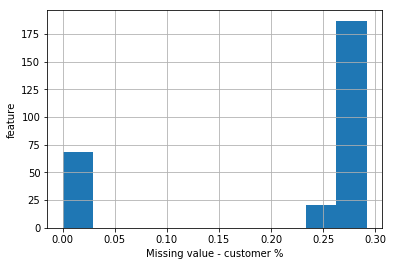

In [32]:
customers_df[annot_attr_customers_values].isnull().mean().hist()
plt.xlabel('Missing value - customer %')
plt.ylabel('feature')
plt.show()

We can find all customers have missing value among documented features are less than 70%.

CUSTOMER DROP CRITERIA: __missing value customers % > 70%__

In [33]:
FEATURE_DROP_RATIO=.7

We create below variable to hold diffent type of feature in `customers_df`

| variable                            |                                                  |
|-------------------------------------|--------------------------------------------------|
| `customers_bin_cat_annot_attribute` | hold `bin_cat_annot_attribute` in `values_df`    |
| `customers_nom_cat_annot_attribute` | hold `nom_cat_annot_attribute` in `values_df`    |
| `customers_ord_cat_annot_attribute` | hold `ord_cat_annot_attribute` in `values_df`    |
| `customers_mix_cat_annot_attribute` | hold `mix_cat_annot_attribute` in `values_df`    |
| `customers_num_annot_attribute`     | hold `num_annot_attribute` in `values_df`        |
| `customers_unused_annot_attribute`  | hold unused features in `values_df`              |

In [34]:
customers_unused_annot_attribute = annot_attr_customers_values[customers_df[annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO]

In [35]:
customers_unused_annot_attribute.size

0

#### Check `customers_bin_cat_annot_attribute`

In [36]:
customers_bin_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, bin_cat_annot_attribute)
customers_bin_cat_annot_attribute = np.setdiff1d(customers_bin_cat_annot_attribute, customers_unused_annot_attribute)

In [37]:
customers_bin_cat_annot_attribute

array(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP'],
      dtype=object)

In [38]:
for col in customers_bin_cat_annot_attribute:
    v1 = customers_df[col].dropna().unique()
    if col == 'OST_WEST_KZ':
        v2 = values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: np.nan if x == -1 else x).dropna().values
    else:
        v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

#### Check `customers_nom_cat_annot_attribute`

In [39]:
customers_nom_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, nom_cat_annot_attribute)
customers_nom_cat_annot_attribute = np.setdiff1d(customers_nom_cat_annot_attribute, customers_unused_annot_attribute)

In [40]:
customers_nom_cat_annot_attribute

array(['AGER_TYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP',
       'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP',
       'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP'],
      dtype=object)

In [41]:
for col in customers_nom_cat_annot_attribute:
    
    unknown_v = []
    if col == 'CAMEO_DEUG_2015':
        v1 = customers_df[col].dropna().apply(lambda x: unknown_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
    else:
        v1 = customers_df[col].dropna().unique()

    if col == 'CAMEO_DEUG_2015' or col == 'CAMEO_DEU_2015':
        v2 = values_df[values_df.Attribute == col]['Value'].values
    else:
        v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
    
    v = np.setdiff1d(v1, v2)
    unknown_v = np.unique(np.array(unknown_v))
    
    if len(unknown_v) > 0:
        print('{} feature has unknown value: {}'.format(col, unknown_v))
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

CAMEO_DEUG_2015 feature has unknown value: ['1' '2' '3' '4' '5' '6' '7' '8' '9' 'X']
CAMEO_DEU_2015 feature has undocumented value: ['XX']
LP_FAMILIE_FEIN feature has undocumented value: [0.]
LP_FAMILIE_GROB feature has undocumented value: [0.]


#### Check `ord_cat_annot_attribute`

In [42]:
customers_ord_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, ord_cat_annot_attribute)
customers_ord_cat_annot_attribute = np.setdiff1d(customers_ord_cat_annot_attribute, customers_unused_annot_attribute)

In [43]:
customers_ord_cat_annot_attribute.size

246

In [44]:
for col in customers_ord_cat_annot_attribute:

    unknown_v = []
    v1 = customers_df[col].dropna().apply(lambda x: unknown_v.append(x) if isinstance(x, str) else x).dropna().unique()

    # assue value of 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM' are as same as 'D19_BANKEN_DATUM'
    if col in ['D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM']:
        col = 'D19_BANKEN_DATUM'
    
    if values_df[values_df.Attribute == col].shape[0] > 0:
        v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
    else:
        v2 = np.array([])

    v = np.setdiff1d(v1, v2)
    unknown_v = np.unique(np.array(unknown_v))
    
    if len(unknown_v) > 0:
        print('{} feature has unknown value: {}'.format(col, unknown_v))
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

ARBEIT feature has undocumented value: [1. 2. 3. 4. 5. 9.]
KBA05_MODTEMP feature has undocumented value: [6.]


#### Check `customers_mix_cat_annot_attribute`

In [45]:
customers_mix_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, mix_cat_annot_attribute)
customers_mix_cat_annot_attribute = np.setdiff1d(customers_mix_cat_annot_attribute, customers_unused_annot_attribute)

In [46]:
customers_mix_cat_annot_attribute

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'], dtype=object)

In [47]:
for col in customers_mix_cat_annot_attribute:
    v1 = customers_df[col].dropna().unique()
    v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

LP_LEBENSPHASE_FEIN feature has undocumented value: [0.]
LP_LEBENSPHASE_GROB feature has undocumented value: [0.]


#### Check `num_annot_attribute`

In [48]:
customers_num_annot_attribute = np.intersect1d(annot_attr_customers_values, num_annot_attribute)
customers_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, customers_unused_annot_attribute)

In [49]:
customers_num_annot_attribute

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'],
      dtype=object)

In [50]:
for col in customers_num_annot_attribute:
    if not np.issubdtype(customers_df[col].dtype, np.number):
        print('{} is not numberic type'.format(col))

#### To fix the error, we will need to ...

1. CAMEO_DEUG_2015: **change '1', '2', '3', '4', '5', '6', '7', '8', '9' to integer, and 'X' to NA**
1. CAMEO_DEU_2015: **change 'XX' to NA**
1. KBA05_MODTEMP: **change 6 to NA**
1. LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB: **chagne 0 to NA**
1. All other attributes: **convert to integer**

In [51]:
assert annot_attr_customers_values.size == customers_bin_cat_annot_attribute.size \
                                            + customers_nom_cat_annot_attribute.size \
                                            + customers_ord_cat_annot_attribute.size \
                                            + customers_mix_cat_annot_attribute.size \
                                            + customers_num_annot_attribute.size \
                                            + customers_unused_annot_attribute.size

#### Check unknown value

We create below variable to hold diffent type of feature in unknown feature in `customers_df`

| variable                                |                                                                           |
|-----------------------------------------|---------------------------------------------------------------------------|
| `customers_unknown_values_df`              | hold 'unknown' meaning feature in `customers_df`                          |
| `customers_main_age_unknown_values_df`     | hold 'unknown / no main age detectable' meaning feature in `customers_df` |
| `customers_transactions_unknown_values_df` | hold 'no transactions known' meaning feature in `customers_df`            |
| `customers_transaction_unknown_values_df`  | hold 'no transaction known' meaning feature in `customers_df`             |

In [52]:
customers_unknown_values_df = unknown_values_df[np.isin(unknown_values_df.Attribute, np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_main_age_unknown_values_df = main_age_unknown_values_df[np.isin(main_age_unknown_values_df.Attribute, np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_transactions_unknown_values_df = transactions_unknown_values_df[np.isin(transactions_unknown_values_df.Attribute, np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_transaction_unknown_values_df = transaction_unknown_values_df[np.isin(transaction_unknown_values_df.Attribute.str[:-3], np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_transaction_unknown_values_df.Attribute = customers_transaction_unknown_values_df.Attribute.str[:-3]

/home/fc/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


##### check `not_annot_attr_customers_values`

In [53]:
customers_df[not_annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 93 columns):
AKT_DAT_KL                    145056 non-null float64
ALTERSKATEGORIE_FEIN          139810 non-null float64
ALTER_KIND1                   11766 non-null float64
ALTER_KIND2                   5100 non-null float64
ALTER_KIND3                   1275 non-null float64
ALTER_KIND4                   236 non-null float64
ANZ_KINDER                    145056 non-null float64
ANZ_STATISTISCHE_HAUSHALTE    141725 non-null float64
CAMEO_INTL_2015               141224 non-null object
CJT_KATALOGNUTZER             188439 non-null float64
CJT_TYP_1                     188439 non-null float64
CJT_TYP_2                     188439 non-null float64
CJT_TYP_3                     188439 non-null float64
CJT_TYP_4                     188439 non-null float64
CJT_TYP_5                     188439 non-null float64
CJT_TYP_6                     188439 non-null float64
CUSTOMER_GROUP                1916

We create below variable to hold differennt type of undocumented features in `customers_df`.

| variable                                |                                                      |
|-----------------------------------------|------------------------------------------------------|
| `customers_bin_cat_not_annot_attribute` | hold binary category feature in `customers_df`       |
| `customers_nom_cat_not_annot_attribute` | hold nominal category feature in `customers_df`      |
| `customers_ord_cat_not_annot_attribute` | hold ordinal categroy feature in `customers_df`      |
| `customers_mix_cat_not_annot_attribute` | hold mix category feature in `customers_df`          |
| `customers_num_not_annot_attribute`     | hold quantative feature in `customers_df`            |
| `customers_unused_not_annot_attribute`  | hold unused features in `customers_df`               |

In [54]:
customers_bin_cat_not_annot_attribute = np.array(['DSL_FLAG', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'SOHO_KZ'])

customers_nom_cat_not_annot_attribute = np.array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'EXTSEL992',
       'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'VK_DHT4A'])

customers_ord_cat_not_annot_attribute = np.array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'CJT_KATALOGNUTZER',
       'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5',
       'CJT_TYP_6', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO',
       'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL',
       'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK',
       'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX',
       'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES',
       'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12',
       'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_REST',
       'D19_VERSICHERUNGEN', 'D19_VERSI_ONLINE_QUOTE_12',
       'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'EINGEZOGENAM_HH_JAHR',
       'FIRMENDICHTE', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3',
       'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ',
       'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER', 'LNR',
       'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
       'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG',
       'UNGLEICHENN_FLAG', 'VHA', 'VHN', 'VK_DISTANZ', 'VK_ZG11', 'ANZ_KINDER'])

customers_mix_cat_not_annot_attribute = np.array(['CAMEO_INTL_2015'])

customers_num_not_annot_attribute = np.array(['ANZ_STATISTISCHE_HAUSHALTE'])

customers_unused_not_annot_attribute = only_attr_customers

In [55]:
assert not_annot_attr_customers_values.size == customers_bin_cat_not_annot_attribute.size \
                                                + customers_nom_cat_not_annot_attribute.size \
                                                + customers_ord_cat_not_annot_attribute.size \
                                                + customers_mix_cat_not_annot_attribute.size \
                                                + customers_num_not_annot_attribute.size \
                                                + customers_unused_not_annot_attribute.size

#### Check missing value

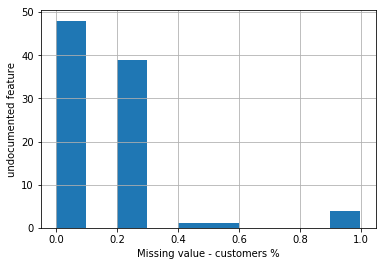

In [56]:
customers_df[not_annot_attr_customers_values].isnull().mean().hist()
plt.xlabel('Missing value - customers %')
plt.ylabel('undocumented feature')
plt.show()

We can find over 70% csutomers still have missing value among about 4 undocumented features.

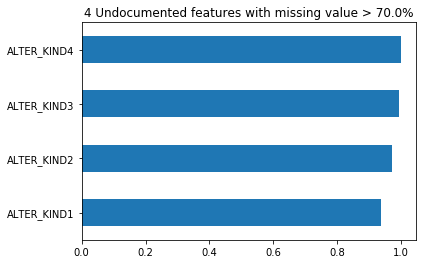

In [57]:
_ = not_annot_attr_customers_values[customers_df[not_annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO]
customers_df[_].isnull().mean().plot.barh()
plt.title('{} Undocumented features with missing value > {}%'.format(_.size, FEATURE_DROP_RATIO*100))
plt.show()

In [58]:
customers_unused_not_annot_attribute = np.union1d(customers_unused_not_annot_attribute, not_annot_attr_customers_values[customers_df[not_annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO])

In [59]:
customers_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

#### Ananlyze EINGEFUEGT_AM

convert datetime string to unix second integer

In [60]:
pd.to_datetime(customers_df['EINGEFUEGT_AM']).describe()

count                  141725
unique                   3034
top       1992-02-10 00:00:00
freq                    64744
first     1992-02-10 00:00:00
last      2016-07-05 00:00:00
Name: EINGEFUEGT_AM, dtype: object

__NOTE__: We will convert datetime string to year based categorical feature

#### Analyze D19_LETZTER_KAUF_BRANCHE

convert string to column index

In [61]:
customers_df['D19_LETZTER_KAUF_BRANCHE'].describe()

count            143955
unique               35
top       D19_UNBEKANNT
freq              31910
Name: D19_LETZTER_KAUF_BRANCHE, dtype: object

In [62]:
customers_df[customers_df['D19_LETZTER_KAUF_BRANCHE'].notna()]['D19_LETZTER_KAUF_BRANCHE'].apply(lambda x: np.where(customers_df.columns == x)[0][0] if x != 'D19_UNBEKANNT' else 0).unique()

array([ 0, 32, 63, 67, 42, 44, 68, 70, 93, 74, 94, 55, 45, 65, 33, 86, 39,
       46, 38, 78, 66, 31, 56, 37, 60, 47, 54, 64, 43, 41, 40, 95, 79, 62,
       59])

__NOTE__: We will change feature string to column index.

#### Analyze CAMEO_INTL_2015

In [63]:
int_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: int_v.append(x) if isinstance(x, int) else x).dropna().unique()

float_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: float_v.append(x) if isinstance(x, float) else x).dropna().unique()

str_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: str_v.append(x) if isinstance(x, str) else x).dropna().unique()

int_v = np.unique(np.array(int_v))
float_v = np.unique(np.array(float_v))
str_v = np.unique(np.array(str_v))

if len(int_v) > 0:
    print('CAMEO_INTL_2015 feature has int value: {}'.format(int_v))
if len(float_v) > 0:
    print('CAMEO_INTL_2015 feature has float value: {}'.format(float_v))
if len(str_v) > 0:
    print('CAMEO_INTL_2015 feature has string value: {}'.format(str_v))

CAMEO_INTL_2015 feature has float value: [12. 13. 14. 15. 22. 23. 24. 25. 31. 32. 33. 34. 35. 41. 43. 44. 45. 51.
 52. 54. 55.]
CAMEO_INTL_2015 feature has string value: ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55' 'XX']


__NOTE__: CAMEO_INTL_2015 combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.

LNR is like serial number

In [64]:
customers_df.shape[0] == customers_df['LNR'].unique().size

True

In [65]:
customers_unused_not_annot_attribute = np.union1d(customers_unused_not_annot_attribute, 'LNR')
customers_ord_cat_not_annot_attribute = np.setdiff1d(customers_ord_cat_not_annot_attribute, 'LNR')

#### To fix the error, we will need to ...

1. ONLINE_PURCHASE, CUSTOMER_GROUP, PRODUCT_GROUP: **drop (not exist in general population)**
1. ALTER_KIND1, ALTER_KIND2, ALTER_KIND3, ALTER_KIND4: **drop (missing value > 70%)**
1. EINGEFUEGT_AM: **convert datetime string to year based categorical feature**
1. D19_LETZTER_KAUF_BRANCHE: **change feature string to column index**
1. CAMEO_INTL_2015: **change '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33' to integer, and 'XX' to NA. Combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.**
1. LNR: **will move it as index to preserve information for segmentation and modeling usage**
1. All other attribute: **convert to integer**

In [66]:
customers_bin_cat_not_annot_attribute = np.setdiff1d(customers_bin_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_nom_cat_not_annot_attribute = np.setdiff1d(customers_nom_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_ord_cat_not_annot_attribute = np.setdiff1d(customers_ord_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_mix_cat_not_annot_attribute = np.setdiff1d(customers_mix_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_num_not_annot_attribute = np.setdiff1d(customers_num_not_annot_attribute, customers_unused_not_annot_attribute)

In [67]:
assert not_annot_attr_customers_values.size == customers_bin_cat_not_annot_attribute.size \
                                                + customers_nom_cat_not_annot_attribute.size \
                                                + customers_ord_cat_not_annot_attribute.size \
                                                + customers_mix_cat_not_annot_attribute.size \
                                                + customers_num_not_annot_attribute.size \
                                                + customers_unused_not_annot_attribute.size

In [68]:
customers_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'CUSTOMER_GROUP', 'LNR', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],
      dtype=object)

#### ROW Viewpoint

#### Check missing value

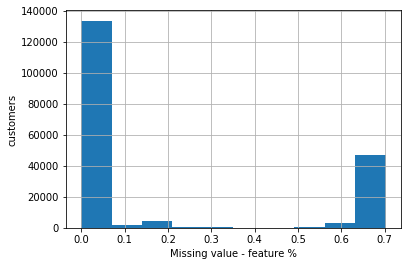

In [69]:
customers_df.isnull().mean(axis=1).hist()
plt.xlabel('Missing value - feature %')
plt.ylabel('customers')
plt.show()

Around 50000 customers (26.76%) have missing value over 30% feature.

In [70]:
customers_df[customers_df.isnull().mean(axis=1) > .7].shape[0]/customers_df.shape[0]

1.5653371736271994e-05

### Data Exploration - general population vs. customers (2nd)
Analyze feature difference between `Udacity_AZDIAS_052018.csv` and `Udacity_CUSTOMERS_052018.csv`

In [71]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


#### Check missing value

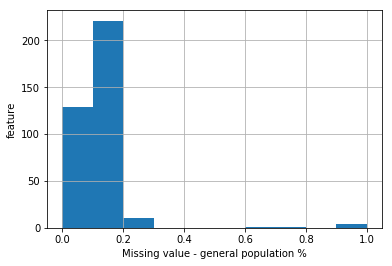

In [72]:
azdias_df.isnull().mean().hist()
plt.xlabel('Missing value - general population %')
plt.ylabel('feature')
plt.show()

Over 70% general population have around 4 feature have missing value.


We create below variable to hold differennt type of documented features in general population.

| variable                         |                                                                |
|----------------------------------|----------------------------------------------------------------|
| `annot_attr_azdias_values`       | to hold below all documented features in general population    |
| `azdias_bin_cat_annot_attribute` | hold `customers_bin_cat_annot_attribute` in general population |
| `azdias_nom_cat_annot_attribute` | hold `customers_nom_cat_annot_attribute` in general population |
| `azdias_ord_cat_annot_attribute` | hold `customers_ord_cat_annot_attribute` in general population |
| `azdias_mix_cat_annot_attribute` | hold `customers_mix_cat_annot_attribute` in general population |
| `azdias_num_annot_attribute`     | hold `customers_num_annot_attribute` in general population     |
| `azdias_unused_annot_attribute`  | hold `customers_unused_annot_attribute` in general population  |

We create below variable to hold differennt type of undocumented features in general population.

| variable                             |                                                                    |
|--------------------------------------|--------------------------------------------------------------------|
| `not_annot_attr_azdias_values`       | hold below all undocumented features in general population         |
| `azdias_bin_cat_not_annot_attribute` | hold `customers_bin_cat_not_annot_attribute` in general population |
| `azdias_nom_cat_not_annot_attribute` | hold `customers_nom_cat_not_annot_attribute` in general population |
| `azdias_ord_cat_not_annot_attribute` | hold `customers_ord_cat_not_annot_attribute` in general population |
| `azdias_mix_cat_not_annot_attribute` | hold `customers_mix_cat_not_annot_attribute` in general population |
| `azdias_num_not_annot_attribute`     | hold `customers_num_not_annot_attribute` in general population     |
| `azdias_unused_not_annot_attribute`  | hold `customers_unused_not_annot_attribute` in general population  |

In [73]:
annot_attr_azdias_values = annot_attr_customers_values
not_annot_attr_azdias_values = np.setdiff1d(not_annot_attr_customers_values, only_attr_customers)

In [74]:
assert annot_attr_azdias_values.size + not_annot_attr_azdias_values.size == customers_df.columns.size - only_attr_customers.size

In [75]:
azdias_unused_annot_attribute = np.intersect1d(azdias_df.columns[azdias_df.isnull().mean() > FEATURE_DROP_RATIO].values, annot_attr_azdias_values)
azdias_unused_annot_attribute = np.union1d(azdias_unused_annot_attribute, customers_unused_annot_attribute)
azdias_bin_cat_annot_attribute = np.setdiff1d(customers_bin_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_nom_cat_annot_attribute = np.setdiff1d(customers_nom_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_ord_cat_annot_attribute = np.setdiff1d(customers_ord_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_mix_cat_annot_attribute = np.setdiff1d(customers_mix_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, azdias_unused_annot_attribute)
azdias_unused_annot_attribute

array([], dtype=object)

In [76]:
assert annot_attr_azdias_values.size == azdias_bin_cat_annot_attribute.size \
                                        + azdias_nom_cat_annot_attribute.size \
                                        + azdias_ord_cat_annot_attribute.size \
                                        + azdias_mix_cat_annot_attribute.size \
                                        + azdias_num_annot_attribute.size \
                                        + azdias_unused_annot_attribute.size

In [77]:
azdias_unused_not_annot_attribute = np.intersect1d(azdias_df.columns[azdias_df.isnull().mean() > FEATURE_DROP_RATIO].values, not_annot_attr_azdias_values)
azdias_unused_not_annot_attribute = np.union1d(azdias_unused_not_annot_attribute, customers_unused_not_annot_attribute)
azdias_unused_not_annot_attribute = np.setdiff1d(azdias_unused_not_annot_attribute, only_attr_customers)
azdias_bin_cat_not_annot_attribute = np.setdiff1d(customers_bin_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_nom_cat_not_annot_attribute = np.setdiff1d(customers_nom_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_ord_cat_not_annot_attribute = np.setdiff1d(customers_ord_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_mix_cat_not_annot_attribute = np.setdiff1d(customers_mix_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_num_not_annot_attribute = np.setdiff1d(customers_num_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'LNR'], dtype=object)

In [78]:
assert not_annot_attr_azdias_values.size == azdias_bin_cat_not_annot_attribute.size \
                                            + azdias_nom_cat_not_annot_attribute.size \
                                            + azdias_ord_cat_not_annot_attribute.size \
                                            + azdias_mix_cat_not_annot_attribute.size \
                                            + azdias_num_not_annot_attribute.size \
                                            + azdias_unused_not_annot_attribute.size

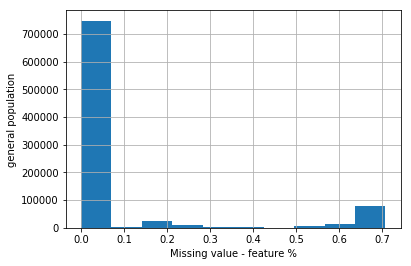

In [79]:
azdias_df.isnull().mean(axis=1).hist()
plt.xlabel('Missing value - feature %')
plt.ylabel('general population')
plt.show()

We need to **check general population value is matched with customers**.

#### Ananlyze `azdias_bin_cat_annot_attribute`

Every category should exist in general population.

In [80]:
for col in azdias_bin_cat_annot_attribute:
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))  

#### Ananlyze `azdias_nom_cat_annot_attribute`

Every category should exist in general population.

In [81]:
for col in azdias_nom_cat_annot_attribute:

    str_azdias_v = []
    str_customers_v = []
    
    if col == 'CAMEO_DEUG_2015':
        
        azdias_v = azdias_df[col].dropna().apply(lambda x: str_azdias_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        customers_v = customers_df[col].dropna().apply(lambda x: str_customers_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        diff_str_azdias_v = np.setdiff1d(str_azdias_v, str_customers_v)
        diff_str_customers_v = np.setdiff1d(str_customers_v, str_azdias_v)
        str_azdias_v = np.unique(str_azdias_v)
        str_customers_v = np.unique(str_customers_v)
        str_azdias_v = []
        str_customers_v = []
    else:
        
        azdias_v = azdias_df[col].dropna().unique()
        customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        
        true_v =  np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
        diff_diff_azdias_v = np.setdiff1d(diff_azdias_v, true_v)
        if diff_diff_azdias_v.size > 0:
            print('{} only in gnneral population : {} <- undocumented'.format(col, diff_diff_azdias_v))
        else:
            print('{} only in gnneral population : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customer : {}'.format(col, diff_customers_v))
    if len(str_azdias_v) > 0:
        print('{} only in general population : {}'.format(col, diff_str_azdias_v))
    if len(str_customers_v) > 0:
        print('{} only in customer : {}'.format(col, diff_str_customers_v))

GEBAEUDETYP only in gnneral population : [5.]
TITEL_KZ only in gnneral population : [2.]


#### Ananlyze `azdias_ord_cat_annot_attribute`

Every category should exist in general population.

In [82]:
for col in azdias_ord_cat_annot_attribute:
    
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        
        true_v =  np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
        diff_diff_azdias_v = np.setdiff1d(diff_azdias_v, true_v)
        if diff_diff_azdias_v.size > 0:
            print('{} only in gnneral population : {} <- undocumented'.format(col, diff_diff_azdias_v))
        else:
            print('{} only in gnneral population : {}'.format(col, diff_azdias_v))
    
    if diff_customers_v.size > 0:
        print('{} only in customer : {}'.format(col, diff_customers_v))

ALTER_HH only in gnneral population : [1.]
D19_BANKEN_ONLINE_QUOTE_12 only in gnneral population : [1.]
KBA05_GBZ only in customer : [0.]
KBA13_AUTOQUOTE only in gnneral population : [0.]
KBA13_KRSAQUOT only in gnneral population : [0.]
KBA13_KRSHERST_AUDI_VW only in gnneral population : [0.]
KBA13_KRSHERST_BMW_BENZ only in gnneral population : [0.]
KBA13_KRSHERST_FORD_OPEL only in gnneral population : [0.]
KBA13_KRSSEG_KLEIN only in gnneral population : [0.]
ORTSGR_KLS9 only in gnneral population : [0.] <- undocumented


__NOTE__: KBA05_GBZ = 0 is unknown, we will drop in data preprocessing stage.

#### Ananlyze `azdias_mix_cat_annot_attribute`

Every category should exist in general population.

In [83]:
for col in azdias_mix_cat_annot_attribute:
    
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))

#### Ananlyze `azdias_num_annot_attribute`

Gnneral population range should cover customer.

In [84]:
for col in azdias_num_annot_attribute:

    min_v1 = azdias_df[col].min()
    max_v1 = azdias_df[col].max()
    min_v2 = customers_df[col].min()
    max_v2 = customers_df[col].max()
    
    if min_v1 > min_v2:
        print('{} in azdias have min value: {} larger than customer: {}'.format(col, min_v1, min_v2))
    if max_v1 < max_v2:
        print('{} in azdias have max value: {} smaller than customer: {}'.format(col, min_v1, min_v2))

#### Ananlyze `azdias_bin_cat_not_annot_attribute`

Every category should exist in general population.

In [85]:
for col in azdias_bin_cat_not_annot_attribute:
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))  

#### Ananlyze `azdias_nom_cat_not_annot_attribute`

Every category should exist in general population.

In [86]:
for col in azdias_nom_cat_not_annot_attribute:
        
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))

EINGEFUEGT_AM different only in azdias : ['1991-06-17 00:00:00' '1991-08-30 00:00:00' '1992-12-17 00:00:00' ...
 '2016-04-20 00:00:00' '2016-05-02 00:00:00' '2016-05-09 00:00:00']
EINGEFUEGT_AM different only in customers_df : ['1993-04-29 00:00:00' '1993-06-02 00:00:00' '1994-09-29 00:00:00'
 '1997-09-15 00:00:00' '1997-12-12 00:00:00' '1998-11-07 00:00:00'
 '1998-11-13 00:00:00' '1999-02-19 00:00:00' '1999-03-16 00:00:00'
 '1999-08-16 00:00:00' '1999-10-25 00:00:00' '2000-12-01 00:00:00'
 '2001-01-02 00:00:00' '2001-01-17 00:00:00' '2001-01-18 00:00:00'
 '2001-03-14 00:00:00' '2001-12-04 00:00:00' '2002-04-26 00:00:00'
 '2003-01-20 00:00:00' '2003-06-28 00:00:00' '2003-12-06 00:00:00'
 '2004-06-12 00:00:00' '2005-05-28 00:00:00' '2005-08-08 00:00:00'
 '2005-10-06 00:00:00' '2006-06-09 00:00:00' '2006-07-01 00:00:00'
 '2006-07-16 00:00:00' '2006-11-10 00:00:00' '2006-12-17 00:00:00'
 '2006-12-23 00:00:00' '2007-03-20 00:00:00' '2007-03-25 00:00:00'
 '2007-03-28 00:00:00' '2007-05-03 0

#### Ananlyze `azdias_ord_cat_not_annot_attribute`

Every category should exist in general population.

In [87]:
for col in azdias_ord_cat_not_annot_attribute:
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()

    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:

        print('{} only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        
        print('{} only in customers_df : {}'.format(col, diff_customers_v))

ALTERSKATEGORIE_FEIN only in azdias : [1.]
ANZ_KINDER only in azdias : [ 9. 11.]
D19_TELKO_ONLINE_QUOTE_12 only in azdias : [7.]
D19_VERSI_ONLINE_QUOTE_12 only in azdias : [3. 6. 8. 9.]
EINGEZOGENAM_HH_JAHR only in azdias : [1900. 1904. 1971. 1984.]


#### Ananlyze `azdias_mix_cat_not_annot_attribute`

Every category should exist in general population.

In [88]:
for col in azdias_mix_cat_not_annot_attribute:
    
    str_azdias_v = []
    str_customers_v = []
    
    if col == 'CAMEO_INTL_2015':
        
        azdias_v = azdias_df[col].dropna().apply(lambda x: str_azdias_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        customers_v = customers_df[col].dropna().apply(lambda x: str_customers_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        diff_str_azdias_v = np.setdiff1d(str_azdias_v, str_customers_v)
        diff_str_customers_v = np.setdiff1d(str_customers_v, str_azdias_v)
        str_azdias_v = np.unique(str_azdias_v)
        str_customers_v = np.unique(str_customers_v)
        str_azdias_v = []
        str_customers_v = []
    else:
        
        azdias_v = azdias_df[col].dropna().unique()
        customers_v = customers_df[col].dropna().unique()
    
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))
    if len(str_azdias_v) > 0:
        print('{} different only in azdias : {}'.format(attr, diff_str_azdias_v))
    if len(str_customers_v) > 0:
        print('{} different only in customers : {}'.format(attr, diff_str_customers_v))

#### Ananlyze `azdias_num_not_annot_attribute`

Gnneral population range should cover customer.

In [89]:
for col in azdias_num_not_annot_attribute:

    min_v1 = azdias_df[col].min()
    max_v1 = azdias_df[col].max()
    min_v2 = customers_df[col].min()
    max_v2 = customers_df[col].max()
    
    if min_v1 > min_v2:
        print('{} in azdias have min value: {} larger than customer: {}'.format(col, min_v1, min_v2))
    if max_v1 < max_v2:
        print('{} in azdias have max value: {} smaller than customer: {}'.format(col, min_v1, min_v2))

#### To fix the error, we will need to ...

1. ORTSGR_KLS9: **change 0 to NA (undocumented in values_df)**

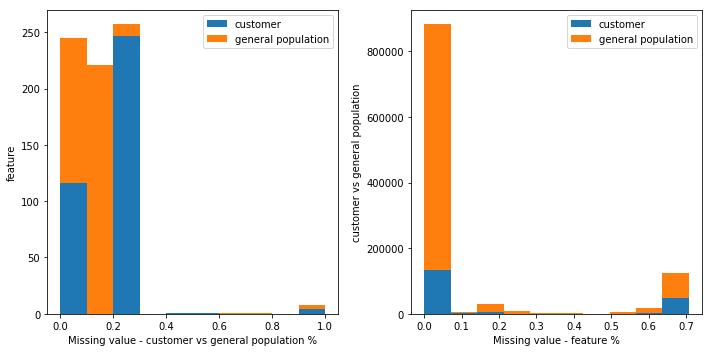

In [90]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((customers_df.isnull().mean(), azdias_df.isnull().mean()), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - customer vs general population %')
plt.ylabel('feature')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((customers_df.isnull().mean(axis=1), azdias_df.isnull().mean(axis=1)), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - feature %')
plt.ylabel('customer vs general population')
plt.legend()

plt.tight_layout()
plt.show()

### Data Preprocessing
Create a `clean_data` function for data cleaning.

#### What we want to do here ...

* `unknown2nd`: Convert all unknown value to NA.
* `formatit`: Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
* Analyze categorical and quantitative feature.
* `drop`: Drop unused features.
* `cover`: Scan feature coverage with general population and customer.
* `log_transform`: Normalize quantitative feature with log transfor.
* `fillna`: Fill every NA field a value. Categorical feature: max, Quantitative feature: median
* `onehot`: Apply one-hot encoding aming nominal categorical features.
* `clean_data`: integrate above procedure to one function.

In [91]:
# dictionary to hold all type of documented features
annot_attr_azdias_values_dict = {
    'bin_cat': azdias_bin_cat_annot_attribute,
    'nom_cat': azdias_nom_cat_annot_attribute,
    'ord_cat': azdias_ord_cat_annot_attribute,
    'mix_cat': azdias_mix_cat_annot_attribute,
    'num': azdias_num_annot_attribute,
    'unused': azdias_unused_annot_attribute
}

# dictionary to hold all type of undocumented features
not_annot_attr_azdias_values_dict = {
    'bin_cat': azdias_bin_cat_not_annot_attribute,
    'nom_cat': azdias_nom_cat_not_annot_attribute,
    'ord_cat': azdias_ord_cat_not_annot_attribute,
    'mix_cat': azdias_mix_cat_not_annot_attribute,
    'num': azdias_num_not_annot_attribute,
    'unused': azdias_unused_not_annot_attribute
}

# dictionary to hold different type of unknow value
unknown_annot_attribute_dict = {
    'unknown': customers_unknown_values_df,
    'main_age_unknown': customers_main_age_unknown_values_df,
    'transaction_unknown': customers_transaction_unknown_values_df,
    'transactions_unknown': customers_transactions_unknown_values_df,
}

new_customers_df = customers_df.copy()
new_azdias_df = azdias_df.copy()

In [92]:
annot_attr_azdias_values = annot_attr_customers_values
assert annot_attr_azdias_values.size == annot_attr_azdias_values_dict['bin_cat'].size \
                                        + annot_attr_azdias_values_dict['nom_cat'].size \
                                        + annot_attr_azdias_values_dict['ord_cat'].size \
                                        + annot_attr_azdias_values_dict['mix_cat'].size \
                                        + annot_attr_azdias_values_dict['num'].size \
                                        + annot_attr_azdias_values_dict['unused'].size

In [93]:
not_annot_attr_azdias_values = np.setdiff1d(not_annot_attr_customers_values, only_attr_customers)
assert not_annot_attr_azdias_values.size == not_annot_attr_azdias_values_dict['bin_cat'].size \
                                            + not_annot_attr_azdias_values_dict['nom_cat'].size \
                                            + not_annot_attr_azdias_values_dict['ord_cat'].size \
                                            + not_annot_attr_azdias_values_dict['mix_cat'].size \
                                            + not_annot_attr_azdias_values_dict['num'].size \
                                            + not_annot_attr_azdias_values_dict['unused'].size

In [94]:
# draw progressbar
def update_progress(progress):
    '''
    INPUT:
    progress - %
    
    OUTPUT:
    
    
    Description: Display a progress bar (https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/)
    '''
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

__NOTE__: `update_progress` is the function used to draw progress bar. Which inspired by [How to display a progress bar in Jupyter Notebook](https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/).

In [95]:
def unknown2na(df, unknown_dict=unknown_annot_attribute_dict):
    '''
    INPUT:
    df - pandas dataframe
    unknown_dict - dictionary to hold all type of unknown string features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Convert all unknown value to NA.
    '''
    cnter = 0
    n_iters = sum([unknown_dict[k].shape[0] for k in unknown_dict.keys()])
    n_iters += 1

    for k in unknown_dict:
        v_df = unknown_dict[k]
        attrs = v_df.Attribute

        for attr in attrs:
            v_unknown = v_df[v_df.Attribute == attr].Value.values[0]
            
            if isinstance(v_unknown, str):
                v_unknown = list(map(int, v_unknown.split(',')))
                df[attr] = df[attr].apply(lambda x: x if not x in v_unknown else np.nan)
            else:
                df[attr] = df[attr].apply(lambda x: x if not x == v_unknown else np.nan)
            
            # Update the progress bar
            cnter+=1 
            update_progress(cnter / n_iters)
    
    update_progress(1)
            
    return df

In [96]:
new_azdias_df = unknown2na(new_azdias_df)

Progress: [####################] 100.0%


In [97]:
new_customers_df = unknown2na(new_customers_df)

Progress: [####################] 100.0%


In [98]:
new_azdias_df.to_pickle('new_azdias_df_unknown2na.pickle')
new_customers_df.to_pickle('new_customers_df_unknown2na.pickle')

In [99]:
new_customers_df = pd.read_pickle("new_customers_df_unknown2na.pickle")
new_azdias_df = pd.read_pickle("new_azdias_df_unknown2na.pickle")

In [100]:
def formatit(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
    '''
    cnter = 0
    n_iters = len([v for k in annot_attr_azdias_values_dict.keys() for v in annot_attr_azdias_values_dict[k] if v in df])
    n_iters += len([v for k in not_annot_attr_azdias_values_dict.keys() for v in not_annot_attr_azdias_values_dict[k] if v in df])
    n_iters += 1

    for k in annot_dict.keys():
        for v in annot_dict[k]:
            if v == 'OST_WEST_KZ':

                # change 'O': 0, 'W': 1
                df[v] = df[v].replace({'O':0, 'W':1})
            elif v == 'CAMEO_DEU_2015':

                # change 'XX' to NA
                df[v] = df[v].replace('XX', np.nan)
            elif v == 'CAMEO_DEUG_2015':

                # change '1', '2', '3', '4', '5', '6', '7', '8', '9' to integer, and 'X' to NA
                df[v] = df[v].replace('X', np.nan)
                df[v] = df[df[v].notna()][v].apply(lambda x: (int(x)))
            elif v == 'KBA05_MODTEMP':

                # change 6 to NA
                df[v] = df[v].replace(6, np.nan)
            elif np.isin(v, ['LP_FAMILIE_FEIN',
                            'LP_FAMILIE_GROB',
                            'LP_LEBENSPHASE_FEIN',
                            'LP_LEBENSPHASE_GROB']):

                # change 0 to NA
                df[v] = df[v].replace(0, np.nan)

            elif v == 'ORTSGR_KLS9':

                # change 0 to NA
                df[v] = df[v].replace(0, np.nan)
            else:

                if v in df:
                    # All other attribute: convert to integer
                    df[v] = df[df[v].notna()][v].apply(lambda x: int(x))

            # Update the progress bar
            cnter+=1 
            update_progress(cnter / n_iters)
    
    for k in not_annot_dict.keys():
        for v in not_annot_dict[k]:
            if v == 'EINGEFUEGT_AM':

                # convert datetime string to year based categorical feature
                df[v] = df[df[v].notna()][v].apply(lambda x: pd.to_datetime(x).year)
            elif v == 'D19_LETZTER_KAUF_BRANCHE':

                # change feature string to column index
                df[v] = df[df[v].notna()][v].apply(lambda x: np.where(customers_df.columns == x)[0][0] if x != 'D19_UNBEKANNT' else 0)
            elif v == 'CAMEO_INTL_2015':

                # change '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33' to integer, and 'XX' to NA
                df[v] = df[df[v].notna()][v].apply(lambda x: int(x) if x != 'XX' else np.nan)
            else:

                if v in df:
                    # All other attribute: convert to integer
                    df[v] = df[df[v].notna()][v].apply(lambda x: int(x))

            # Update the progress bar
            cnter+=1 
            update_progress(cnter / n_iters)
    
    update_progress(1)
    
    return df

In [101]:
new_azdias_df = formatit(new_azdias_df)

Progress: [####################] 100.0%


In [102]:
new_customers_df = formatit(new_customers_df)

Progress: [####################] 100.0%


In [103]:
new_azdias_df.to_pickle('new_azdias_df_formatit.pickle')
new_customers_df.to_pickle('new_customers_df_formatit.pickle')

In [104]:
new_azdias_df = pd.read_pickle("new_azdias_df_formatit.pickle")
new_customers_df = pd.read_pickle("new_customers_df_formatit.pickle")

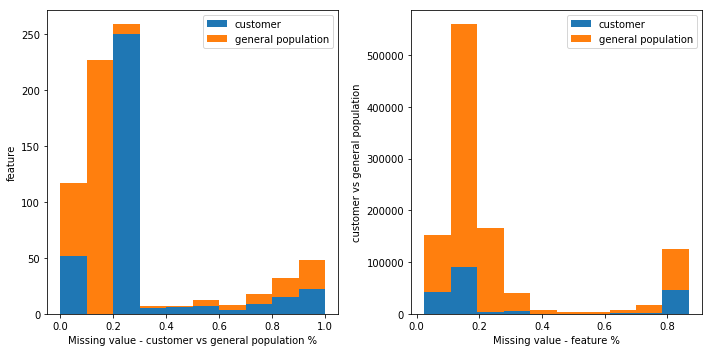

In [105]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((new_customers_df.isnull().mean(), new_azdias_df.isnull().mean()), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - customer vs general population %')
plt.ylabel('feature')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((new_customers_df.isnull().mean(axis=1), new_azdias_df.isnull().mean(axis=1)), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - feature %')
plt.ylabel('customer vs general population')
plt.legend()

plt.tight_layout()
plt.show()

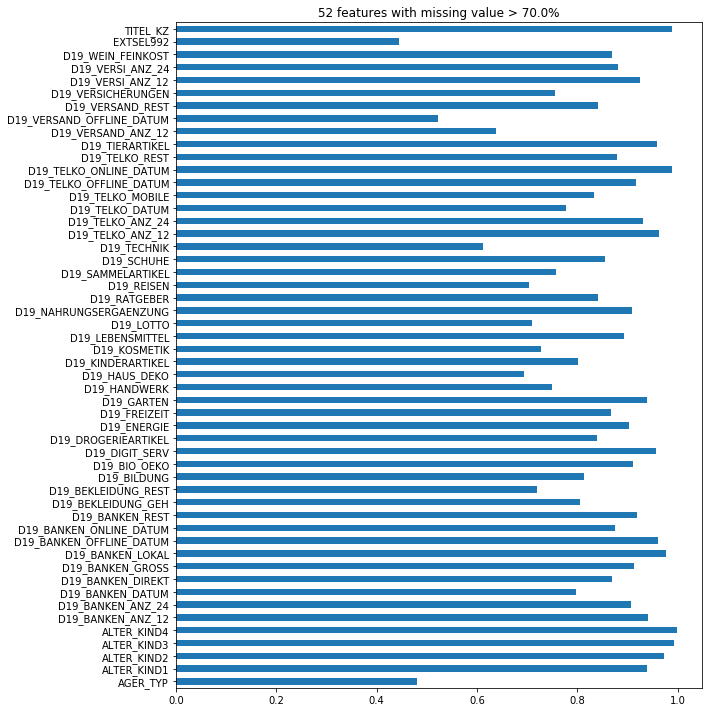

In [106]:
_ = np.setdiff1d(new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO], annot_attr_azdias_values_dict['unused'])
_ = np.union1d(_, np.setdiff1d(new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO], not_annot_attr_azdias_values_dict['unused']))

plt.figure(figsize = [10, 10])
new_customers_df[_].isnull().mean().plot.barh()
plt.title('{} features with missing value > {}%'.format(np.setdiff1d(_, 'LNR').size, FEATURE_DROP_RATIO*100))
plt.tight_layout()
plt.show()

#### Analyze categorical feature

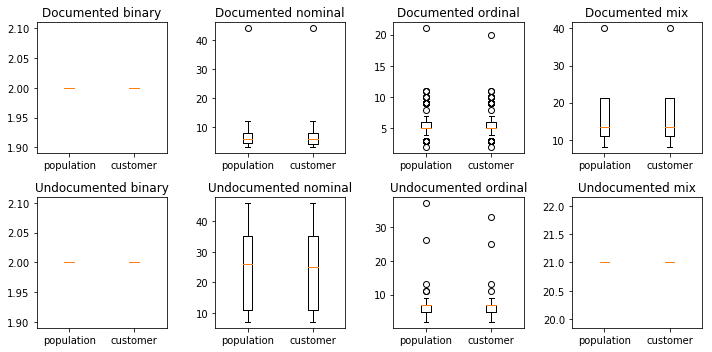

In [107]:
plt.figure(figsize = [10, 5])

plt.subplot(2,4,1)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['bin_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['bin_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented binary')

plt.subplot(2,4,2)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['nom_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['nom_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented nominal')

plt.subplot(2,4,3)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['ord_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['ord_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented ordinal')

plt.subplot(2,4,4)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['mix_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['mix_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented mix')

plt.subplot(2,4,5)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['bin_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['bin_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented binary')

plt.subplot(2,4,6)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['nom_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['nom_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented nominal')

plt.subplot(2,4,7)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['ord_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['ord_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented ordinal')

plt.subplot(2,4,8)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['mix_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['mix_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented mix')

plt.tight_layout()
plt.show()

After browse value range of different type features, we would like to drop feature outliers.
* **Nominal categorical feature have more than 15 values: drop**
* **Ordinal categorical feature have more than 15 values: drop**

Analyze `annot_attr_azdias_values_dict['nom_cat']`

In [108]:
for v in annot_attr_azdias_values_dict['nom_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

CAMEO_DEU_2015 have 44 unique values (>15)


__NOTE__: drop CAMEO_DEU_2015 (44 unique value, too large)

Analyze `annot_attr_azdias_values_dict['ord_cat']`

In [109]:
for v in annot_attr_azdias_values_dict['ord_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

ALTER_HH have 21 unique values (>15)


__NOTE__: drop ALTER_HH (21 unique value, too large)

Analyze `annot_attr_azdias_values_dict['mix_cat']`

LP_LEBENSPHASE_FEIN: **contains information about life stage and fine scale. I will create two new ordinals features, one for life_stage and other for fine_scale**

In [110]:
age_dict = {'younger_age': 0, 'middle_age': 1, 'advanced_age': 2, 'retirement_age': 3}
life_stage = {1: age_dict['younger_age'], 2: age_dict['middle_age'], 3: age_dict['younger_age'],
              4: age_dict['middle_age'], 5: age_dict['advanced_age'], 6: age_dict['retirement_age'],
              7: age_dict['advanced_age'], 8: age_dict['retirement_age'], 9: age_dict['middle_age'],
              10: age_dict['middle_age'], 11: age_dict['advanced_age'], 12: age_dict['retirement_age'],
              13: age_dict['advanced_age'], 14: age_dict['younger_age'], 15: age_dict['advanced_age'],
              16: age_dict['advanced_age'], 17: age_dict['middle_age'], 18: age_dict['younger_age'],
              19: age_dict['advanced_age'], 20: age_dict['advanced_age'], 21: age_dict['middle_age'],
              22: age_dict['middle_age'], 23: age_dict['middle_age'], 24: age_dict['middle_age'],
              25: age_dict['middle_age'], 26: age_dict['middle_age'], 27: age_dict['middle_age'],
              28: age_dict['middle_age'], 29: age_dict['younger_age'], 30: age_dict['younger_age'],
              31: age_dict['advanced_age'], 32: age_dict['advanced_age'], 33: age_dict['younger_age'],
              34: age_dict['younger_age'], 35: age_dict['younger_age'], 36: age_dict['advanced_age'],
              37: age_dict['advanced_age'], 38: age_dict['retirement_age'], 39: age_dict['middle_age'],
              40: age_dict['retirement_age']}

fine_dict = {'low': 0, 'average': 1, 'wealthy': 2, 'top': 3}                                                                                      
fine_scale = {1: fine_dict['low'], 2: fine_dict['low'], 3: fine_dict['average'], 4: fine_dict['average'], 5: fine_dict['low'], 6: fine_dict['low'],
              7: fine_dict['average'], 8: fine_dict['average'], 9: fine_dict['average'], 10: fine_dict['wealthy'], 11: fine_dict['average'],
              12: fine_dict['average'], 13: fine_dict['top'], 14: fine_dict['average'], 15: fine_dict['low'], 16: fine_dict['average'],
              17: fine_dict['average'], 18: fine_dict['wealthy'], 19: fine_dict['wealthy'], 20: fine_dict['top'], 21: fine_dict['low'],
              22: fine_dict['average'], 23: fine_dict['wealthy'], 24: fine_dict['low'], 25: fine_dict['average'], 26: fine_dict['average'],
              27: fine_dict['average'], 28: fine_dict['top'], 29: fine_dict['low'], 30: fine_dict['average'], 31: fine_dict['low'],
              32: fine_dict['average'], 33: fine_dict['average'], 34: fine_dict['average'], 35: fine_dict['top'], 36: fine_dict['average'],
              37: fine_dict['average'], 38: fine_dict['average'], 39: fine_dict['top'], 40: fine_dict['top']}

# create LP_life_stage and LP_fine_scale column
new_azdias_df['LP_life_stage'] = new_azdias_df['LP_LEBENSPHASE_FEIN'].map(life_stage)
new_azdias_df['LP_fine_scale'] = new_azdias_df['LP_LEBENSPHASE_FEIN'].map(fine_scale)
new_customers_df['LP_life_stage'] = new_customers_df['LP_LEBENSPHASE_FEIN'].map(life_stage)
new_customers_df['LP_fine_scale'] = new_customers_df['LP_LEBENSPHASE_FEIN'].map(fine_scale)

LP_LEBENSPHASE_GROB **contains the same information as LP_LEBENSPHASE_FEIN. Therefore I will drop it.**

PRAEGENDE_JUGENDJAHRE: **combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.**

In [111]:
# Map decade
dec_dic = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
           15: 90, np.nan: np.nan, -1: np.nan, 0: np.nan}

# Map mouvement
mov_dic = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
           np.nan: np.nan, -1: np.nan, 0: np.nan}

# create PRAEGENDE_JUGENDJAHRE_dec and PRAEGENDE_JUGENDJAHRE_mov column
new_azdias_df['PRAEGENDE_JUGENDJAHRE_dec'] = new_azdias_df['PRAEGENDE_JUGENDJAHRE'].map(dec_dic)
new_azdias_df['PRAEGENDE_JUGENDJAHRE_mov'] = new_azdias_df['PRAEGENDE_JUGENDJAHRE'].map(mov_dic)
new_customers_df['PRAEGENDE_JUGENDJAHRE_dec'] = new_customers_df['PRAEGENDE_JUGENDJAHRE'].map(dec_dic)
new_customers_df['PRAEGENDE_JUGENDJAHRE_mov'] = new_customers_df['PRAEGENDE_JUGENDJAHRE'].map(mov_dic)

WOHNLAGE: **We create two new features NEIGHBORHOOD_QUALITY (Ordinal, vaulues from 1 to 5) and RURAL (Binary, 0= non-rural, 1=rural)**

In [112]:
neighbor_dict = {}
rural_dict = {0: 0, 1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1}

# create WOHNLAGE_rural and WOHNLAGE_neighborhood_quality column
new_azdias_df['WOHNLAGE_rural'] = new_azdias_df['WOHNLAGE'].map(rural_dict)
new_azdias_df['WOHNLAGE_neighborhood_quality'] = new_azdias_df[(new_azdias_df['WOHNLAGE'] >= 0) & (new_azdias_df['WOHNLAGE'] < 7)]['WOHNLAGE']

In [113]:
new_customers_df['WOHNLAGE_rural'] = new_customers_df['WOHNLAGE'].map(rural_dict)
new_customers_df['WOHNLAGE_neighborhood_quality'] = new_customers_df[(new_customers_df['WOHNLAGE'] >= 0) & (new_customers_df['WOHNLAGE'] < 7)]['WOHNLAGE']

Analyze `not_annot_attr_azdias_values_dict['nom_cat']`

In [114]:
for v in not_annot_attr_azdias_values_dict['nom_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

D19_LETZTER_KAUF_BRANCHE have 35 unique values (>15)
EINGEFUEGT_AM have 26 unique values (>15)
VERDICHTUNGSRAUM have 46 unique values (>15)


__NOTE__: drop D19_LETZTER_KAUF_BRANCHE (35 unique value, too large) ,drop EINGEFUEGT_AM (26 unique value, too large), drop VERDICHTUNGSRAUM (46 unique value, too large)

Analyze `not_annot_attr_azdias_values_dict['ord_cat']`

In [115]:
for v in not_annot_attr_azdias_values_dict['ord_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

ALTERSKATEGORIE_FEIN have 26 unique values (>15)
EINGEZOGENAM_HH_JAHR have 37 unique values (>15)


__NOTE__: drop ALTERSKATEGORIE_FEIN (26 unique value, too large), drop EINGEZOGENAM_HH_JAHR (37 unique value, too large)

Analyze `not_annot_attr_azdias_values_dict['mix_cat']`

In [116]:
# create CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_family column
new_azdias_df['CAMEO_INTL_2015_wealth'] = new_azdias_df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
new_azdias_df['CAMEO_INTL_2015_family'] = new_azdias_df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)

# create CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_family column
new_customers_df['CAMEO_INTL_2015_wealth'] = new_customers_df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
new_customers_df['CAMEO_INTL_2015_family'] = new_customers_df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan) 

#### Analyze quantitative feature

In [117]:
num_cols = np.union1d(annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['num'])
num_cols

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'GEBURTSJAHR',
       'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'], dtype=object)

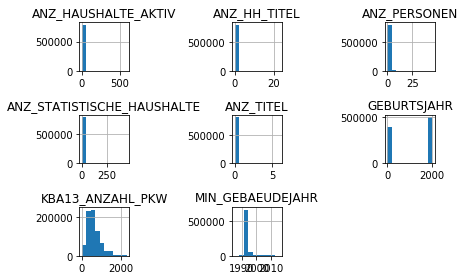

In [118]:
for i in range(num_cols.size):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[num_cols[i]].hist(ax=ax)
    plt.title(num_cols[i])

plt.tight_layout()
plt.show()

__NOTE__: 
1. ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, ANZ_PERSONEN, ANZ_STATISTISCHE_HAUSHALTE, ANZ_TITEL: log transform

Analyze GEBURTSJAHR (year of birth)

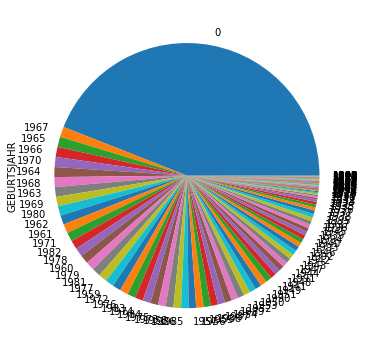

In [119]:
plt.figure(figsize = [10, 5])
azdias_df['GEBURTSJAHR'].value_counts().plot.pie()
plt.tight_layout()
plt.show()

__NOTE__: GEBURTSJAHR: drop (almost half are year of birth = 0, abnormal)

In [120]:
col_outlier = np.array(['ALTERSKATEGORIE_FEIN', 'ALTER_HH',
       'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
       'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'VERDICHTUNGSRAUM', 'WOHNLAGE'])

In [121]:
annot_attr_azdias_values = np.union1d(annot_attr_azdias_values, ['LP_life_stage', 
                                                                 'LP_fine_scale', 
                                                                 'PRAEGENDE_JUGENDJAHRE_dec', 
                                                                 'PRAEGENDE_JUGENDJAHRE_mov',
                                                                 'WOHNLAGE_rural',
                                                                 'WOHNLAGE_neighborhood_quality'])

annot_attr_azdias_values_dict['unused'] = np.union1d(annot_attr_azdias_values_dict['unused'], annot_attr_azdias_values_dict['mix_cat'])
annot_attr_azdias_values_dict['unused'] = np.union1d(annot_attr_azdias_values_dict['unused'], ['CAMEO_DEU_2015', 'ALTER_HH', 'GEBURTSJAHR'])
annot_attr_azdias_values_dict['mix_cat'] = np.array([])
annot_attr_azdias_values_dict['bin_cat'] = np.union1d(annot_attr_azdias_values_dict['bin_cat'], 'WOHNLAGE_rural')
annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['nom_cat'], 'CAMEO_DEU_2015')
annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['ord_cat'], 'ALTER_HH')
annot_attr_azdias_values_dict['ord_cat'] = np.union1d(annot_attr_azdias_values_dict['ord_cat'], ['WOHNLAGE_neighborhood_quality'])
annot_attr_azdias_values_dict['nom_cat'] = np.union1d(annot_attr_azdias_values_dict['nom_cat'], ['LP_life_stage', \
                                                                                                 'LP_fine_scale', \
                                                                                                 'PRAEGENDE_JUGENDJAHRE_dec', \
                                                                                                 'PRAEGENDE_JUGENDJAHRE_mov'])
annot_attr_azdias_values_dict['num'] = np.setdiff1d(annot_attr_azdias_values_dict['num'], ['GEBURTSJAHR'])

not_annot_attr_azdias_values = np.union1d(not_annot_attr_azdias_values, ['CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_family'])

not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], not_annot_attr_azdias_values_dict['mix_cat'])
not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM'])
not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], ['ALTERSKATEGORIE_FEIN', 'EINGEZOGENAM_HH_JAHR'])                                                 
not_annot_attr_azdias_values_dict['mix_cat'] = np.array([])
not_annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['nom_cat'], ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM'])
not_annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['ord_cat'], ['ALTERSKATEGORIE_FEIN', 'EINGEZOGENAM_HH_JAHR'])
not_annot_attr_azdias_values_dict['nom_cat'] = np.union1d(not_annot_attr_azdias_values_dict['nom_cat'], ['CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_family'])

In [122]:
annot_attr_azdias_values_dict['unused'] = np.union1d(annot_attr_azdias_values_dict['unused'], \
                                np.intersect1d(np.concatenate(list(annot_attr_azdias_values_dict.values())), new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO]))
annot_attr_azdias_values_dict['bin_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['bin_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['nom_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['ord_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['mix_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['mix_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['num'] = np.setdiff1d(annot_attr_azdias_values_dict['num'], annot_attr_azdias_values_dict['unused'])

/home/fc/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [123]:
not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], \
                                np.intersect1d(np.concatenate(list(not_annot_attr_azdias_values_dict.values())), new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO]))
not_annot_attr_azdias_values_dict['bin_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['bin_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['nom_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['ord_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['mix_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['mix_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['num'] = np.setdiff1d(not_annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['unused'])

In [124]:
assert annot_attr_azdias_values.size == annot_attr_azdias_values_dict['bin_cat'].size \
                                        + annot_attr_azdias_values_dict['nom_cat'].size \
                                        + annot_attr_azdias_values_dict['ord_cat'].size \
                                        + annot_attr_azdias_values_dict['mix_cat'].size \
                                        + annot_attr_azdias_values_dict['num'].size \
                                        + annot_attr_azdias_values_dict['unused'].size

In [125]:
assert not_annot_attr_azdias_values.size == not_annot_attr_azdias_values_dict['bin_cat'].size \
                                            + not_annot_attr_azdias_values_dict['nom_cat'].size \
                                            + not_annot_attr_azdias_values_dict['ord_cat'].size \
                                            + not_annot_attr_azdias_values_dict['mix_cat'].size \
                                            + not_annot_attr_azdias_values_dict['num'].size \
                                            + not_annot_attr_azdias_values_dict['unused'].size

Move LNR as index to preserve information for segmentation and modeling usage

In [126]:
new_azdias_df.set_index('LNR', inplace=True)
new_customers_df.set_index('LNR', inplace=True)

In [127]:
def drop(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Drop unused features.
    '''  
    ## drop ferature
    cols = [v for k in annot_dict.keys() for v in annot_dict[k]]
    cols += [v for k in not_annot_dict.keys() for v in not_annot_dict[k]]
    cols = np.setdiff1d(cols, annot_dict['unused'])
    cols = np.setdiff1d(cols, not_annot_dict['unused'])
    df = df[cols]
    
    return df

In [128]:
new_azdias_df = drop(new_azdias_df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict)
new_customers_df = drop(new_customers_df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict)

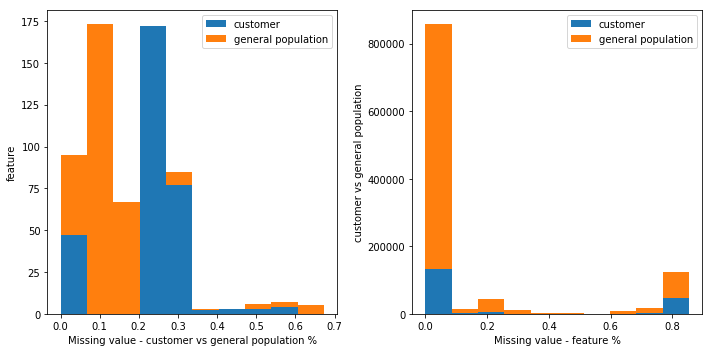

In [129]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((new_customers_df.isnull().mean(), new_azdias_df.isnull().mean()), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - customer vs general population %')
plt.ylabel('feature')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((new_customers_df.isnull().mean(axis=1), new_azdias_df.isnull().mean(axis=1)), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - feature %')
plt.ylabel('customer vs general population')
plt.legend()

plt.tight_layout()
plt.show()

In [130]:
new_azdias_df.to_pickle('new_azdias_df_drop.pickle')
new_customers_df.to_pickle('new_customers_df_drop.pickle')

In [131]:
new_azdias_df = pd.read_pickle("new_azdias_df_drop.pickle")
new_customers_df = pd.read_pickle("new_customers_df_drop.pickle")

In [132]:
def log_transform(df, cols):
    '''
    INPUT:
    df - pandas dataframe
    cols - log transfer comlumns
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Normalize quantitative feature with log transfor.
    '''
    for col in cols:
        if col == 'MIN_GEBAEUDEJAHR':
            df[col] = np.log1p(df[col] - df[col].min())
        else:
            df[col] = np.log1p(df[col])
    
    return df

In [133]:
log_cols = np.array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL'])
log_cols

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL'], dtype='<U26')

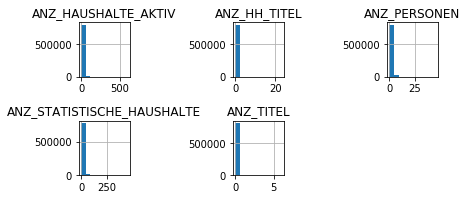

In [134]:
for i in range(log_cols.size):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[log_cols[i]].hist(ax=ax)
    plt.title(log_cols[i])

plt.tight_layout()
plt.show()

In [135]:
new_azdias_df = log_transform(new_azdias_df, log_cols)

/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log1p
  app.launch_new_instance()


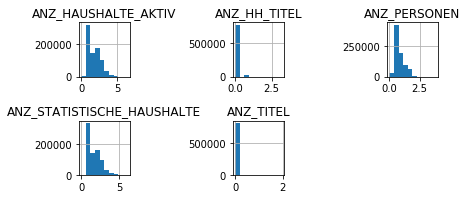

In [136]:
for i in range(log_cols.size):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[log_cols[i]].hist(ax=ax)
    plt.title(log_cols[i])

plt.tight_layout()
plt.show()

In [137]:
new_customers_df = log_transform(new_customers_df, log_cols)

/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log1p
  app.launch_new_instance()


In [138]:
new_azdias_df.to_pickle('new_azdias_df_log.pickle')
new_customers_df.to_pickle('new_customers_df_log.pickle')

In [139]:
new_azdias_df = pd.read_pickle("new_azdias_df_log.pickle")
new_customers_df = pd.read_pickle("new_customers_df_log.pickle")

In [140]:
def cap_outlier(df, cols):
    '''
    INPUT:
    df - pandas dataframe
    cols - find outlier columns
    ratio - ratio feature are all outlier will be considered as true outlier
    
    OUTPUT:
    df - pandas dataframe
    
    Description: 
    '''
    outliers  = pd.Series([])
    sol = []
    
    i = 0

    # For each feature find the data points with extreme high or low values
    for col in cols:
        #Capping the outlier rows with Percentiles
        upper_lim = df[col].quantile(.95)
        lower_lim = df[col].quantile(.05)
        
        df.loc[(df[col] > upper_lim),col] = upper_lim
        df.loc[(df[col] < lower_lim),col] = lower_lim

    
    return df

In [141]:
num_cols = np.union1d(annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['num'])
num_cols

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW',
       'MIN_GEBAEUDEJAHR'], dtype=object)

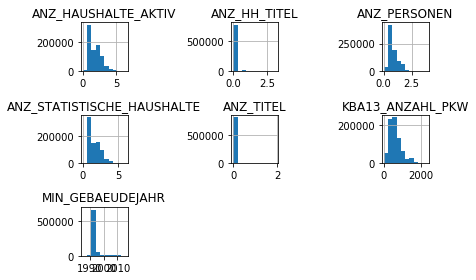

In [142]:
for i, col in enumerate(num_cols):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[col].hist(ax=ax)
    plt.title(col)

plt.tight_layout()
plt.show()

In [143]:
new_azdias_df = cap_outlier(new_azdias_df, num_cols)

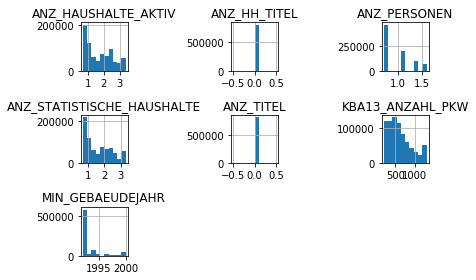

In [144]:
for i, col in enumerate(num_cols):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[col].hist(ax=ax)
    plt.title(col)

plt.tight_layout()
plt.show()

In [145]:
new_customers_df = cap_outlier(new_customers_df, num_cols)

In [146]:
new_azdias_df.to_pickle('new_azdias_df_outlier.pickle')
new_customers_df.to_pickle('new_customers_df_outlier.pickle')

In [147]:
new_azdias_df = pd.read_pickle("new_azdias_df_outlier.pickle")
new_customers_df = pd.read_pickle("new_customers_df_outlier.pickle")

In [148]:
def cover(population_df, sample_df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    population_df - pandas dataframe for general population
    sample_df - pandas dataframe for sample
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    Description: Scan feature overlay with population and sample.
    '''
    for col in population_df.columns:
        if col in sample_df:
            if not np.isin(col, np.union1d(annot_dict['num'], not_annot_dict['num'])):       
                population_v = population_df[col].dropna().unique()
                sample_v = sample_df[col].dropna().unique()

                diff_population_v = np.setdiff1d(population_v, sample_v)
                diff_sample_v = np.setdiff1d(sample_v, population_v)

                if diff_sample_v.size > 0:
                    print('{} have value only in sample : {} -> drop'.format(col, diff_sample_v))
                    sample_df.loc[sample_df[col].isin(diff_sample_v), col] = np.nan
                    
                if col in annot_dict['nom_cat'].tolist()+not_annot_dict['nom_cat'].tolist():
                    if diff_population_v.size > 0:
                        print('nom_cat type {} have value only in population : {} -> drop'.format(col, diff_population_v))
                        population_df.loc[population_df[col].isin(diff_population_v), col] = np.nan

            else:
                max_population_v = population_df[col].dropna().max()
                min_population_v = population_df[col].dropna().min()

                max_sample_v = sample_df[col].dropna().max()
                min_sample_v = sample_df[col].dropna().min()

                if min_population_v > min_sample_v:
                    print('{} in general population have min value: {} larger than sample: {} -> drop'.format(col, min_population_v, min_sample_v))
                    sample_df.loc[sample_df[col] < min_population_v, col] = np.nan
                if max_population_v < max_sample_v:
                    print('{} in general population have max value: {} smaller than sample: {} -> drop'.format(col, max_population_v, max_sample_v))
                    sample_df.loc[sample_df[col] > max_population_v, col] = np.nan

In [149]:
cover(new_azdias_df, new_customers_df)

ANZ_PERSONEN in general population have max value: 1.6094379124341003 smaller than sample: 1.791759469228055 -> drop
nom_cat type GEBAEUDETYP have value only in population : [5.] -> drop
KBA13_ANZAHL_PKW in general population have max value: 1300.0 smaller than sample: 1400.0 -> drop


In [150]:
def fillna(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Fill every NA field a value. Categorical feature: max, Quantitative feature: median
    '''
    cat_cols = annot_dict['bin_cat'].tolist() + not_annot_dict['bin_cat'].tolist() \
                + annot_dict['nom_cat'].tolist() + not_annot_dict['nom_cat'].tolist() \
                + annot_dict['ord_cat'].tolist() + not_annot_dict['ord_cat'].tolist()
    for col in df.columns:
        if col in cat_cols:
            # cztegorical feature
            # Max fill function for categorical
            df[col] = df[col].fillna(df[col].value_counts().idxmax())
            
        else:
            # quantitaive feature
            # Filling missing values with medians of the columns
            df[col] = df[col].fillna(df[col].median())
    return df

In [151]:
new_azdias_df = fillna(new_azdias_df)

In [152]:
new_customers_df = fillna(new_customers_df)

In [153]:
new_azdias_df.to_pickle('new_azdias_df_fillna.pickle')

In [154]:
assert new_azdias_df.isnull().mean().sum() == 0

In [155]:
def onehot(df, cols):
    '''
    INPUT:
    df - pandas dataframe
    cols - columns to perform one-hot encoding
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Apply one-hot encoding aming nominal categorical features.
    '''
    for col in cols:
        dummy_df = pd.get_dummies(df[col], prefix=col, prefix_sep='_')
        
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(col, axis=1), dummy_df], axis=1)
    
    return df

In [156]:
onehot_cols = np.union1d(annot_attr_azdias_values_dict['nom_cat'], not_annot_attr_azdias_values_dict['nom_cat'])
onehot_cols

array(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015_family',
       'CAMEO_INTL_2015_wealth', 'CJT_GESAMTTYP', 'D19_KONSUMTYP',
       'FINANZTYP', 'GEBAEUDETYP', 'GEMEINDETYP', 'GFK_URLAUBERTYP',
       'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_fine_scale', 'LP_life_stage', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE_dec', 'PRAEGENDE_JUGENDJAHRE_mov',
       'SHOPPER_TYP', 'VK_DHT4A', 'ZABEOTYP'], dtype=object)

In [157]:
new_azdias_df.shape

(891221, 308)

In [158]:
new_azdias_df = onehot(new_azdias_df, onehot_cols)

In [159]:
new_azdias_df.shape

(891221, 410)

In [160]:
new_customers_df = onehot(new_customers_df, onehot_cols)

In [161]:
assert new_azdias_df.shape[1] == new_customers_df.shape[1]

In [162]:
new_azdias_df.to_pickle('new_azdias_df_onehot.pickle')
new_customers_df.to_pickle('new_customers_df_onehot.pickle')

### Put it all together

Create a `clean_data` function to apply all steps of Data Preprocessing.

In [163]:
def mix_cat(df):
    '''
    INPUT:
    df - pandas dataframe
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Create nom_cat column from mix_cat column.
    '''
    # map LP_LEBENSPHASE_FEIN to LP_life_stage and LP_fine_scale
    age_dict = {'younger_age': 0, 'middle_age': 1, 'advanced_age': 2, 'retirement_age': 3}
    life_stage = {1: age_dict['younger_age'], 2: age_dict['middle_age'], 3: age_dict['younger_age'],
                  4: age_dict['middle_age'], 5: age_dict['advanced_age'], 6: age_dict['retirement_age'],
                  7: age_dict['advanced_age'], 8: age_dict['retirement_age'], 9: age_dict['middle_age'],
                  10: age_dict['middle_age'], 11: age_dict['advanced_age'], 12: age_dict['retirement_age'],
                  13: age_dict['advanced_age'], 14: age_dict['younger_age'], 15: age_dict['advanced_age'],
                  16: age_dict['advanced_age'], 17: age_dict['middle_age'], 18: age_dict['younger_age'],
                  19: age_dict['advanced_age'], 20: age_dict['advanced_age'], 21: age_dict['middle_age'],
                  22: age_dict['middle_age'], 23: age_dict['middle_age'], 24: age_dict['middle_age'],
                  25: age_dict['middle_age'], 26: age_dict['middle_age'], 27: age_dict['middle_age'],
                  28: age_dict['middle_age'], 29: age_dict['younger_age'], 30: age_dict['younger_age'],
                  31: age_dict['advanced_age'], 32: age_dict['advanced_age'], 33: age_dict['younger_age'],
                  34: age_dict['younger_age'], 35: age_dict['younger_age'], 36: age_dict['advanced_age'],
                  37: age_dict['advanced_age'], 38: age_dict['retirement_age'], 39: age_dict['middle_age'],
                  40: age_dict['retirement_age']}
    fine_dict = {'low': 0, 'average': 1, 'wealthy': 2, 'top': 3}                                                                                      
    fine_scale = {1: fine_dict['low'], 2: fine_dict['low'], 3: fine_dict['average'], 4: fine_dict['average'], 5: fine_dict['low'], 6: fine_dict['low'],
                  7: fine_dict['average'], 8: fine_dict['average'], 9: fine_dict['average'], 10: fine_dict['wealthy'], 11: fine_dict['average'],
                  12: fine_dict['average'], 13: fine_dict['top'], 14: fine_dict['average'], 15: fine_dict['low'], 16: fine_dict['average'],
                  17: fine_dict['average'], 18: fine_dict['wealthy'], 19: fine_dict['wealthy'], 20: fine_dict['top'], 21: fine_dict['low'],
                  22: fine_dict['average'], 23: fine_dict['wealthy'], 24: fine_dict['low'], 25: fine_dict['average'], 26: fine_dict['average'],
                  27: fine_dict['average'], 28: fine_dict['top'], 29: fine_dict['low'], 30: fine_dict['average'], 31: fine_dict['low'],
                  32: fine_dict['average'], 33: fine_dict['average'], 34: fine_dict['average'], 35: fine_dict['top'], 36: fine_dict['average'],
                  37: fine_dict['average'], 38: fine_dict['average'], 39: fine_dict['top'], 40: fine_dict['top']}
    # create LP_life_stage and LP_fine_scale column
    df['LP_life_stage'] = df['LP_LEBENSPHASE_FEIN'].map(life_stage)
    df['LP_fine_scale'] = df['LP_LEBENSPHASE_FEIN'].map(fine_scale)
    
    # map PRAEGENDE_JUGENDJAHRE to PRAEGENDE_JUGENDJAHRE_dec and PRAEGENDE_JUGENDJAHRE_mov
    # Map decade
    dec_dic = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
               8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
               15: 90, np.nan: np.nan, -1: np.nan, 0: np.nan}
    # Map mouvement
    mov_dic = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
               9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
               np.nan: np.nan, -1: np.nan, 0: np.nan}
    # create PRAEGENDE_JUGENDJAHRE_dec and PRAEGENDE_JUGENDJAHRE_mov column
    df['PRAEGENDE_JUGENDJAHRE_dec'] = df['PRAEGENDE_JUGENDJAHRE'].map(dec_dic)
    df['PRAEGENDE_JUGENDJAHRE_mov'] = df['PRAEGENDE_JUGENDJAHRE'].map(mov_dic)
    
    # map WOHNLAGE
    rural_dict = {1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1}
    # create WOHNLAGE_rural and WOHNLAGE_neighborhood_quality column
    df['WOHNLAGE_rural'] = df['WOHNLAGE'].map(rural_dict)
    df['WOHNLAGE_neighborhood_quality'] = df[(df['WOHNLAGE'] >= 0) & (df['WOHNLAGE'] < 7)]['WOHNLAGE']
    
    # map CAMEO_INTL_2015 to CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_family
    # create CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_family column
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_family'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    return df

In [164]:
def clean_data(df):
    
    if 'RESPONSE' in df:
        not_annot_attr_azdias_values_dict['bin_cat'] = np.union1d(not_annot_attr_azdias_values_dict['bin_cat'], ['RESPONSE'])
    else:
        not_annot_attr_azdias_values_dict['bin_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['bin_cat'], ['RESPONSE'])
    
    # Convert all unknown value to NA.
    print('unknown2na...')
    df = unknown2na(df)
    
    # Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
    print('formatit...')
    df = formatit(df)
    
    # Create nom_cat column from mix_cat column.
    clear_output(wait = False)
    print('mix_cat...')
    df = mix_cat(df)
    
    # More LNR as index
    df.set_index('LNR', inplace=True)
    
    # Drop unused features.
    print('drop...')
    df = drop(df)
    
    # Normalize quantitative feature with log transfor
    print('log_transform...')
    cols = np.array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL'])
    df = log_transform(df, cols)
    
    print('cap outlier...')
    cols = num_cols
    df = cap_outlier(df, cols)
    
    # Scan feature overlay with population and sample.
    print('cover...')
    new_azdias_df = pd.read_pickle("new_azdias_df_fillna.pickle")
    cover(new_azdias_df, df)
    
    # Fill every NA field a value. Categorical feature: max, Quantitative feature: median
    print('fillna...')
    df = fillna(df)
    
    # Apply one-hot encoding aming nominal categorical features.
    print('onehot...')
    cols = np.union1d(annot_attr_azdias_values_dict['nom_cat'], not_annot_attr_azdias_values_dict['nom_cat'])
    df = onehot(df, cols)
    
    print('clean_data successfully :)')
    
    return df

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### What we want to do here ...

* Feature Transformation
    - Scaling
    - PCA
        - PCA: Use PCA to find how many components, `N_COMPONENTS`,will best describe total feature variance.
        - Dimensionality Reduction: User `N_COMPONENTS` to create new simplified dataframe.
* Clustering
    - Identidy cluster: Use `MiniBatchKMeans` to fast find `N_CLUSTERS` for K-Meana algorithm.
    - Create cluster: Apply K-Means with `N_CLUSTERS` to customer and general population,
* Data Recovery
    - Map `N cluster` to original space. Then, select 2 cluster as target, the most customer like, and non-target, the least customer like. Finally, compare over and under represented features between these 2 culsters.
* Conclusion

### Feature Transformation

In [165]:
new_customers_df = pd.read_pickle("new_customers_df_onehot.pickle")
new_azdias_df = pd.read_pickle("new_azdias_df_onehot.pickle")

In [166]:
assert new_azdias_df.shape[1] == new_customers_df.shape[1]

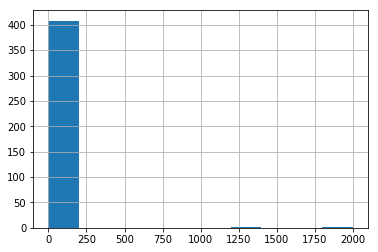

In [167]:
new_azdias_df.max().hist()
plt.show()

#### Scaling

Perform StandardScaler to best handle outliers.

In [168]:
scaler = StandardScaler()

In [169]:
scaler_new_azdias_df = pd.DataFrame(scaler.fit_transform(new_azdias_df.values), columns=new_azdias_df.columns, index=new_azdias_df.index)
scaler_new_customers_df = pd.DataFrame(scaler.fit_transform(new_customers_df.values), columns=new_customers_df.columns, index=new_customers_df.index)

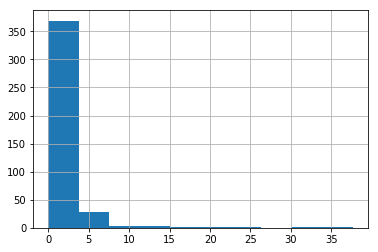

In [170]:
scaler_new_azdias_df.max().hist()
plt.show()

#### PCA

What we want to do here ...

* **PCA**: Use PCA to find how many components, `N_COMPONENTS`,will best describe total feature variance.
* **Dimensionality Reduction**: User `N_COMPONENTS` to create new simplified dataframe.

In [171]:
# Apply PCA by fitting the good data with the same number of dimensions as features
new_azdias_pca = PCA().fit(scaler_new_azdias_df)

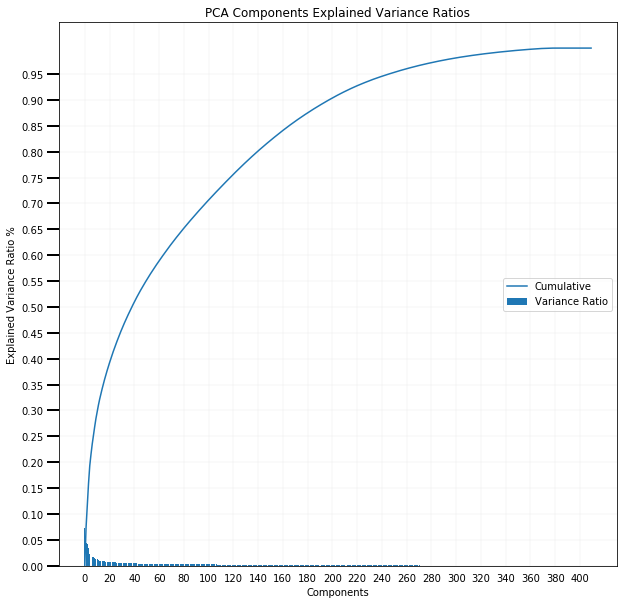

In [172]:
def show_pca(pca):
    """    
    INPUT:
        pca: an sklearn.decomposition.pca.PCA object    
    
    OUTPUT:
        None (visualizes a plot)
    
    DESCRIPTION:
        Visualize the curves of the explained variance ratio for each component and the cumulative ratios
    """
    cumulative_ratios=np.zeros(len(pca.explained_variance_ratio_))
    
    for i in range(len(pca.explained_variance_ratio_)):
        cumulative_ratios[i]=np.sum(pca.explained_variance_ratio_[:i])
        
    plt.figure(figsize=(10,10))
    
    plt.bar(x=np.arange(len(pca.explained_variance_ratio_)), height=pca.explained_variance_ratio_)
    plt.plot(cumulative_ratios)
    
    plt.xlabel("Components")
    plt.ylabel("Explained Variance Ratio %")
    plt.title("PCA Components Explained Variance Ratios")
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.xticks(np.arange(0, len(pca.explained_variance_ratio_)+2, step=(len(pca.explained_variance_ratio_) // 20)))
    plt.tick_params(axis='x', width=0)
    plt.tick_params(axis='y', width=2, length=12)
    plt.grid(linewidth=0.1)
    plt.legend(['Cumulative', 'Variance Ratio'], loc='center right')
    
show_pca(new_azdias_pca)

We can use first 200 principal component to cover 90% variance.

In [173]:
sum(new_azdias_pca.explained_variance_ratio_[:200])

0.9036260035688192

In [174]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(new_azdias_pca.components_)+1)]

# PCA components
new_azdias_components_pca_df = pd.DataFrame(np.round(new_azdias_pca.components_, 4), columns = new_azdias_df.keys())
new_azdias_components_pca_df.index = dimensions

In [175]:
new_azdias_components_pca_df.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A_8.0,VK_DHT4A_9.0,VK_DHT4A_10.0,VK_DHT4A_11.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
Dimension 1,0.0498,-0.0326,0.0061,0.1392,-0.0,-0.0288,-0.0767,0.1349,0.0,0.0927,...,0.0159,0.0173,0.0487,0.0118,-0.0728,-0.0382,0.0235,0.0025,0.0417,0.0273
Dimension 2,0.0125,0.0123,-0.0007,0.0338,0.0,-0.0079,-0.0057,0.0341,-0.0,-0.0317,...,0.0045,0.0086,-0.0074,-0.0013,0.0161,0.0061,-0.0055,-0.0095,-0.0081,0.0087
Dimension 3,0.0262,-0.1534,0.0049,0.0051,0.0,0.0845,0.0684,0.0042,-0.0,-0.0208,...,-0.0238,-0.0266,-0.0784,0.0080,0.0248,0.0297,-0.1579,0.1067,0.0722,-0.0109
Dimension 4,-0.0280,0.0813,-0.0175,0.0360,0.0,0.0249,0.0991,0.0466,0.0,0.0282,...,-0.0131,-0.0213,-0.1224,-0.0049,0.0295,0.0165,-0.0350,0.0239,-0.0310,0.0104
Dimension 5,-0.1097,-0.0092,0.0523,-0.0268,0.0,0.0205,0.0307,-0.0363,-0.0,0.1320,...,-0.0586,-0.0619,0.0694,-0.0133,-0.0096,0.0388,0.0565,-0.0167,-0.0406,-0.0463


#### Dimension 1

In [266]:
top5_1st_pos = new_azdias_components_pca_df.iloc[0].sort_values(ascending=False)[:5]
top5_1st_pos

ANZ_HAUSHALTE_AKTIV           0.1392
PLZ8_ANTG3                    0.1366
KBA13_ANTG3                   0.1365
ANZ_STATISTISCHE_HAUSHALTE    0.1349
KBA13_BAUMAX                  0.1217
Name: Dimension 1, dtype: float64

In [267]:
top5_1st_neg = new_azdias_components_pca_df.iloc[0].sort_values(ascending=False)[-1:-6:-1]
top5_1st_neg

PLZ8_ANTG1       -0.1376
KBA13_ANTG1      -0.1368
LP_STATUS_FEIN   -0.1316
LP_STATUS_GROB   -0.1313
MOBI_RASTER      -0.1306
Name: Dimension 1, dtype: float64

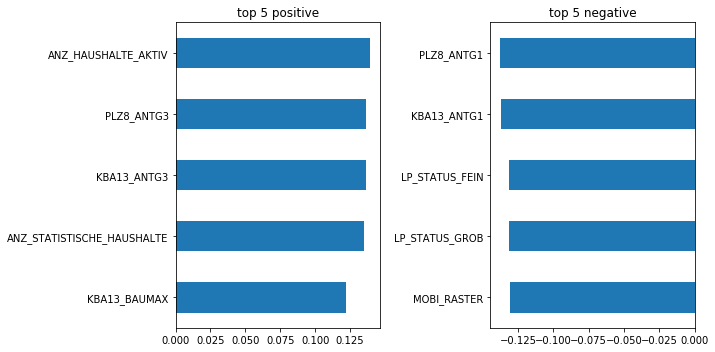

In [268]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
top5_1st_pos.sort_values(ascending=True).plot.barh()
plt.title('top 5 positive')

plt.subplot(1,2,2)
top5_1st_neg.sort_values(ascending=False).plot.barh()
plt.title('top 5 negative')

plt.tight_layout()
plt.show()

**Postiive correlation**
* D19_VERSAND_ONLINE_QUOTE_12    0.7116 (amount of online transactions within all transactions in the segment mail-order)
* D19_BANKEN_ONLINE_QUOTE_12     0.1184 (amount of online transactions within all transactions in the segment bank)
* D19_GESAMT_ONLINE_QUOTE_12     0.1175 (amount of online transactions within all transactions in the complete file)
* ONLINE_AFFINITAET              0.1039 (online affinity)
* KBA05_AUTOQUOT                 0.1029 (share of cars per household)

**Negative correlation**
* D19_VERSI_DATUM               -0.1535 (undocumented)
* PLZ8_BAUMAX                   -0.1298 (most common building-type within the PLZ8)
* KBA13_ANTG3                   -0.1043 (undocumented)
* PLZ8_ANTG3                    -0.1007 (number of 6-10 family houses in the PLZ8)
* VK_DISTANZ                    -0.0917 (undocumented)

The first principal component have strong positive correlation online behavior, Have strong negative correlation to large family building.

#### Second principal component

In [269]:
top5_2nd_pos = new_azdias_components_pca_df.iloc[1].sort_values(ascending=False)[:5]
top5_2nd_pos

KBA13_HERST_BMW_BENZ           0.1806
KBA13_SEG_OBEREMITTELKLASSE    0.1541
KBA13_MERCEDES                 0.1539
KBA13_BMW                      0.1514
KBA13_SITZE_4                  0.1456
Name: Dimension 2, dtype: float64

In [270]:
top5_2nd_neg = new_azdias_components_pca_df.iloc[1].sort_values(ascending=False)[-1:-6:-1]
top5_2nd_neg

KBA13_SITZE_5          -0.1475
KBA13_KMH_140_210      -0.1291
KBA13_SEG_KLEINWAGEN   -0.1266
KBA13_HALTER_25        -0.1177
KBA13_HALTER_20        -0.1164
Name: Dimension 2, dtype: float64

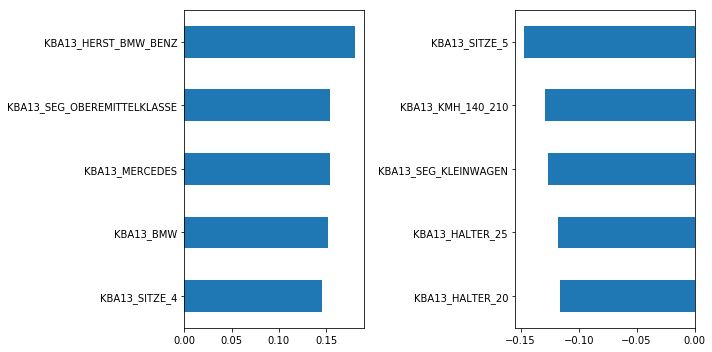

In [271]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
top5_2nd_pos.sort_values(ascending=True).plot.barh()

plt.subplot(1,2,2)
top5_2nd_neg.sort_values(ascending=False).plot.barh()

plt.tight_layout()
plt.show()

**Postiive correlation**
* D19_VERSAND_ONLINE_QUOTE_12    0.4445 (amount of online transactions within all transactions in the segment mail-order)
* KBA13_SITZE_5                  0.1143 (number of cars with 5 seats in the PLZ8)
* KBA13_KMH_180                  0.1121 (share of cars with max speed between 110 km/h and 180km/h within the PLZ8)
* KBA13_KMH_140_210              0.1117 (share of cars with max speed between 140 and 210 km/h within the PLZ8)
* KBA13_SEG_KLEINWAGEN           0.1115 (share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8)

**Negative correlation**
* KBA13_KMH_211                 -0.1901 (share of cars with a greater max speed than 210 km/h within the PLZ8)
* KBA13_KMH_250                 -0.1881 (share of cars with max speed between 210 and 250 km/h within the PLZ8)
* KBA13_KW_121                  -0.1735 (share of cars with an engine power more than 120 KW - PLZ8)
* KBA13_CCM_2501                -0.1697 (share of cars with more than 2500ccm within the PLZ8)
* KBA13_SEG_SPORTWAGEN          -0.1583 (share of sportscars within the PLZ8)

The second principal component have strong positive correlation to big space, small car. Have strong negative correlation to high performance, luxury car.

#### Third principal component

In [272]:
top5_3rd_pos = new_azdias_components_pca_df.iloc[2].sort_values(ascending=False)[:5]
top5_3rd_pos

FINANZ_SPARER        0.1684
CJT_TYP_1            0.1681
CJT_TYP_2            0.1659
ONLINE_AFFINITAET    0.1631
SEMIO_TRADV          0.1558
Name: Dimension 3, dtype: float64

In [273]:
top5_3rd_neg = new_azdias_components_pca_df.iloc[2].sort_values(ascending=False)[-1:-6:-1]
top5_3rd_neg

CJT_TYP_4          -0.1715
CJT_TYP_5          -0.1709
FINANZ_VORSORGER   -0.1683
CJT_TYP_3          -0.1682
CJT_TYP_6          -0.1657
Name: Dimension 3, dtype: float64

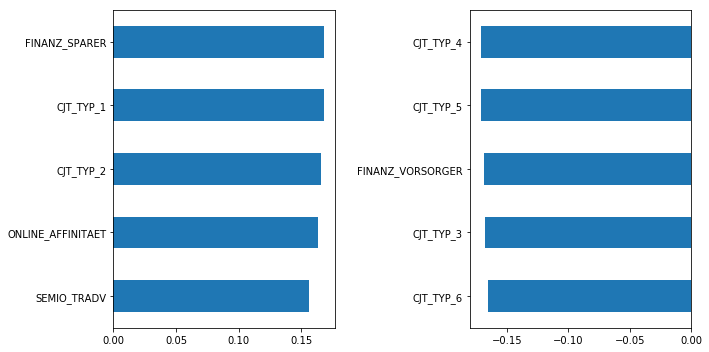

In [274]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
top5_3rd_pos.sort_values(ascending=True).plot.barh()

plt.subplot(1,2,2)
top5_3rd_neg.sort_values(ascending=False).plot.barh()

plt.tight_layout()
plt.show()

**Postiive correlation**
* D19_VERSAND_ONLINE_QUOTE_12    0.3629 (amount of online transactions within all transactions in the segment mail-order)
* PLZ8_BAUMAX                    0.2321 (most common building-type within the PLZ8)
* KBA13_ANTG3                    0.1525 (undocumented)
* PLZ8_ANTG3                     0.1466 (number of 6-10 family houses in the PLZ8)
* KBA13_BAUMAX                   0.1222 (undocumented)

**Negative correlation**
* KBA13_ALTERHALTER_60          -0.1678 (share of car owners between 46 and 60 within the PLZ8)
* KBA13_AUTOQUOTE               -0.1635 (share of cars per household within the PLZ8)
* FIRMENDICHTE                  -0.1573 (undocumented)
* KBA13_HALTER_55               -0.1566 (share of car owners between 51 and 55 within the PLZ8)
* KBA13_HALTER_50               -0.1450 (share of car owners between 46 and 50 within the PLZ8)

The third principal component have strong positive correlation to online behavior and large family building. Have strong negative correlation to older car owner.

#### Dimensionality Reduction

User `N_COMPONENTS` to create new simplified dataframe.

In [182]:
N_COMPONENTS = 200 # first 200 principal component cover 95% variance.

# Apply PCA by fitting the good data with only 50 dimensions
new_azdias_pca = PCA(n_components=N_COMPONENTS).fit(scaler_new_azdias_df)

# Transform the general population using the PCA fit above
reduced_data_new_azdias = new_azdias_pca.transform(scaler_new_azdias_df)

# Transform the customer using the PCA fit above
reduced_data_new_customers = new_azdias_pca.transform(scaler_new_customers_df)

# Create a DataFrame for the reduced data
new_azdias_reduced_data_df = pd.DataFrame(reduced_data_new_azdias, columns = ['Dimension '+str(i) for i in range(1, N_COMPONENTS+1)])
new_customers_reduced_data_df = pd.DataFrame(reduced_data_new_customers, columns = ['Dimension '+str(i) for i in range(1, N_COMPONENTS+1)])

In [183]:
new_azdias_reduced_data_df.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 191,Dimension 192,Dimension 193,Dimension 194,Dimension 195,Dimension 196,Dimension 197,Dimension 198,Dimension 199,Dimension 200
0,2.615773,-1.356127,-3.993948,-5.534264,4.499242,-2.680841,0.428217,1.946446,-0.759959,-0.716427,...,0.037377,-0.231643,-0.115300,0.110456,0.179107,0.226942,-0.431733,0.601999,0.367237,-0.315536
1,4.733825,5.216691,5.585039,-3.700904,-3.116672,2.006158,-4.811736,0.869314,2.456966,-0.565094,...,-1.359087,0.022536,0.327927,-0.649038,1.050765,-0.781430,0.021370,1.201146,0.236507,0.170792
2,-1.104587,2.704192,0.911635,-3.404724,0.934241,4.309492,-0.108340,-7.838126,-0.699011,-0.988529,...,-0.256296,-1.264199,0.239953,0.229221,-0.142222,-0.136539,-0.098243,0.514019,1.297310,-0.558902
3,-5.933334,0.159957,-4.007203,-2.930395,-3.008452,0.543769,-2.744139,0.100234,-0.308147,2.967654,...,-0.713698,0.836347,-0.435748,0.014360,-0.476715,-0.883722,1.302982,-0.794209,-0.050528,0.676778
4,-3.009852,2.878877,4.529021,5.929090,2.647338,-5.015142,2.255576,0.735301,-4.340580,0.599266,...,-0.181789,-0.027922,-0.516872,0.103872,0.055799,-0.628340,-0.437203,1.463858,-0.275150,-1.029666


### Clustering

What we want to do here ...
* **Identidy cluster**: Use MiniBatchKMeans to fast find `N_CLUSTERS` for K-Meana algorithm.
* **Create cluster**: Apply K-Means with `N_CLUSTERS` to customer and general population,

#### Identify cluster

Use `MiniBatchKMeans` to fast find `N_CLUSTERS` for K-Meana algorithm.

In [184]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1,31))
for center in centers:
    
    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(n_clusters=center, random_state=27)
    model = kmeans.fit(reduced_data_new_azdias)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(reduced_data_new_azdias))
    scores.append(score)

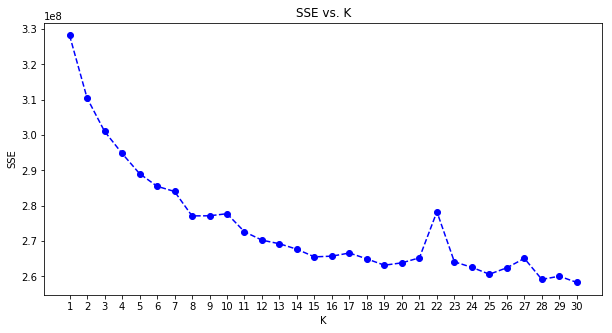

In [185]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(10, 5))
ax = plt.subplot()
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.xticks(np.arange(1, 31, step=1))
plt.ylabel('SSE');
plt.title('SSE vs. K');

#### Create cluster

Apply K-Means with `N_CLUSTERS` to customer and general population,

In [186]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
N_CLUSTERS = 20

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=27, n_jobs=N_JOBS)

# predict cluster of general population
azdias_preds = kmeans.fit_predict(reduced_data_new_azdias)

In [187]:
# pca reduced data with cluster information of general population
cluster_new_azdias_reduced_data_df = new_azdias_reduced_data_df
cluster_new_azdias_reduced_data_df['Cluster'] = azdias_preds # add cluster column
cluster_new_azdias_reduced_data_df.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 192,Dimension 193,Dimension 194,Dimension 195,Dimension 196,Dimension 197,Dimension 198,Dimension 199,Dimension 200,Cluster
0,2.615773,-1.356127,-3.993948,-5.534264,4.499242,-2.680841,0.428217,1.946446,-0.759959,-0.716427,...,-0.231643,-0.115300,0.110456,0.179107,0.226942,-0.431733,0.601999,0.367237,-0.315536,14
1,4.733825,5.216691,5.585039,-3.700904,-3.116672,2.006158,-4.811736,0.869314,2.456966,-0.565094,...,0.022536,0.327927,-0.649038,1.050765,-0.781430,0.021370,1.201146,0.236507,0.170792,9
2,-1.104587,2.704192,0.911635,-3.404724,0.934241,4.309492,-0.108340,-7.838126,-0.699011,-0.988529,...,-1.264199,0.239953,0.229221,-0.142222,-0.136539,-0.098243,0.514019,1.297310,-0.558902,1
3,-5.933334,0.159957,-4.007203,-2.930395,-3.008452,0.543769,-2.744139,0.100234,-0.308147,2.967654,...,0.836347,-0.435748,0.014360,-0.476715,-0.883722,1.302982,-0.794209,-0.050528,0.676778,8
4,-3.009852,2.878877,4.529021,5.929090,2.647338,-5.015142,2.255576,0.735301,-4.340580,0.599266,...,-0.027922,-0.516872,0.103872,0.055799,-0.628340,-0.437203,1.463858,-0.275150,-1.029666,6


In [188]:
# predict cluster of customer
customers_preds = kmeans.fit_predict(reduced_data_new_customers)

In [189]:
# pca reduced data with cluster information of customer
cluster_new_customers_reduced_data_df = new_customers_reduced_data_df
cluster_new_customers_reduced_data_df['Cluster'] = customers_preds  # add cluster column
cluster_new_customers_reduced_data_df.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 192,Dimension 193,Dimension 194,Dimension 195,Dimension 196,Dimension 197,Dimension 198,Dimension 199,Dimension 200,Cluster
0,-7.228267,3.514195,-3.229177,-0.864378,-3.716867,0.656356,1.898678,0.313630,-1.058259,-1.300073,...,-1.536867,0.613652,0.183195,-0.203617,0.093643,0.074952,-0.138735,0.600203,-0.969986,0
1,0.261333,-2.122838,-3.518635,-1.245646,-0.454159,0.398131,2.040532,1.589340,-0.233285,-0.493615,...,-0.407775,-0.014103,-0.367179,1.589847,0.510266,0.975810,0.706518,0.112572,0.390424,1
2,4.057679,3.704632,-5.258961,-0.056886,-0.487292,-4.239404,0.996862,-0.776801,3.505281,7.753820,...,-0.158397,0.649776,0.687192,-0.337859,-0.471303,-0.085243,-0.681862,0.235993,-0.470853,11
3,-3.720188,-2.935956,-2.531900,0.028579,-2.148335,6.419840,-1.195359,1.057266,-5.034449,0.392094,...,-0.471383,-1.416636,-0.110284,1.662177,0.399058,0.341276,0.081515,-0.078393,-0.402576,0
4,5.366211,-2.580167,6.393793,2.962754,-0.810222,-5.809247,-0.179852,0.329225,-1.422193,-3.016306,...,0.003982,-0.351891,-0.607100,0.014189,-0.420291,0.099712,0.218786,0.546898,-0.523527,9


In [190]:
cluster_new_azdias_reduced_data_df.shape, cluster_new_customers_reduced_data_df.shape

((891221, 201), (191652, 201))

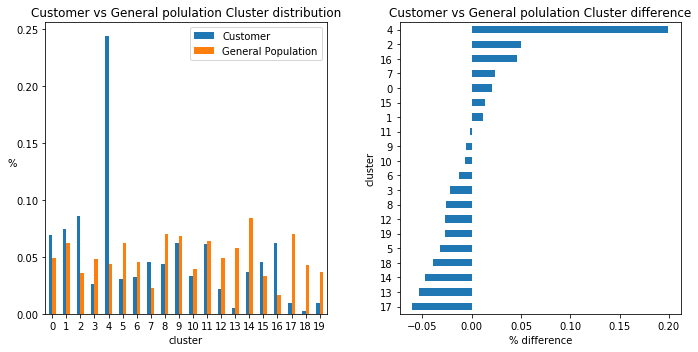

In [191]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(121)
pd.DataFrame({'Customer': pd.Series(customers_preds).value_counts()/customers_preds.size, 'General Population': pd.Series(azdias_preds).value_counts()/azdias_preds.size}).plot.bar(rot=0, ax=ax1)
plt.xlabel('cluster')
plt.ylabel('%').set_rotation(0)
plt.title('Customer vs General polulation Cluster distribution')

ax2 = plt.subplot(122)
_ = (pd.Series(customers_preds).value_counts()/customers_preds.size - pd.Series(azdias_preds).value_counts()/azdias_preds.size).sort_values()
target_cluster = _.index[-1] # the most customer like clusters
non_target_cluster = _.index[0] # the most customer like clusters
_.plot.barh(ax=ax2)
plt.xlabel('% difference')
plt.ylabel('cluster')
plt.title('Customer vs General polulation Cluster difference')

plt.tight_layout()
plt.show()

In [192]:
target_cluster, non_target_cluster

(4, 17)

### Data Recovery

Map N cluster to original space. Then, select 2 cluster as target, for the most customer like, and non-target, the least customer like. Finally, compare over and under represented features between these 2 culsters.

In [193]:
# add cluster and LNR to original data
inv_cluster_new_azdias_reduced_data_df = new_azdias_pca.inverse_transform(cluster_new_azdias_reduced_data_df.drop('Cluster', axis=1))
inv_cluster_new_azdias_reduced_data_df = pd.DataFrame(scaler.inverse_transform(inv_cluster_new_azdias_reduced_data_df), columns=new_azdias_df.columns)
inv_cluster_new_azdias_reduced_data_df.set_index(new_azdias_df.index, inplace=True)  # add LNR column
inv_cluster_new_azdias_reduced_data_df['Cluster'] = cluster_new_azdias_reduced_data_df['Cluster'].values  # add cluster column
inv_cluster_new_azdias_reduced_data_df.reset_index(inplace=True)
inv_cluster_new_azdias_reduced_data_df.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A_9.0,VK_DHT4A_10.0,VK_DHT4A_11.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,Cluster
0,910215,0.381754,2.441808,1.309425,1.199368,2.099674e-16,-0.061940,1.000573,1.056282,6.588447e-18,...,-0.022788,0.453871,-0.000017,0.229885,0.026762,1.068137,-0.043771,-0.036897,-0.023376,14
1,910220,4.466345,1.238101,1.856837,2.097214,-1.072645e-15,0.151007,1.309314,2.067129,3.759970e-16,...,-0.054638,-0.097584,-0.000937,0.177200,0.007766,0.093181,-0.067948,0.235182,-0.028415,9
2,910225,3.676416,3.473280,1.779322,1.343075,2.811205e-16,-0.033591,0.940606,1.360821,-5.904290e-16,...,0.667396,-0.083490,-0.000143,0.002278,-0.019550,0.326432,-0.100086,0.238193,-0.047300,1
3,910226,-0.233764,3.831814,1.666549,0.496065,4.355038e-17,-0.025066,0.879777,0.516116,3.824403e-16,...,0.003888,-0.016098,-0.000261,0.236661,0.036512,0.990128,-0.044956,-0.019419,-0.026350,8
4,910241,0.414435,3.685043,0.589239,0.870694,-1.325329e-15,0.020490,1.552445,0.834757,-7.923396e-16,...,-0.021994,-0.022626,-0.000330,0.189035,-0.005736,0.219969,0.511814,-0.039635,-0.002407,6


In [194]:
# add cluster and LNR to original data
inv_cluster_new_customers_reduced_data_df = new_azdias_pca.inverse_transform(cluster_new_customers_reduced_data_df.drop('Cluster', axis=1))
inv_cluster_new_customers_reduced_data_df = pd.DataFrame(scaler.inverse_transform(inv_cluster_new_customers_reduced_data_df), columns=new_customers_df.columns)
inv_cluster_new_customers_reduced_data_df.set_index(new_customers_df.index, inplace=True)  # add LNR column
inv_cluster_new_customers_reduced_data_df['Cluster'] = cluster_new_customers_reduced_data_df['Cluster'].values  # add cluster column
inv_cluster_new_customers_reduced_data_df.reset_index(inplace=True)
inv_cluster_new_customers_reduced_data_df.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A_9.0,VK_DHT4A_10.0,VK_DHT4A_11.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,Cluster
0,9626,1.237621,4.153311,0.742207,0.974411,7.513953e-16,0.047753,1.046208,0.939417,9.341212e-16,...,-0.017406,-0.036274,-0.000079,0.140790,0.031585,0.878215,-0.016493,0.011433,-0.012315,0
1,9628,7.260979,3.711254,0.879349,0.836426,-5.738710e-17,-0.023119,1.201561,0.768273,-4.847293e-16,...,0.017994,0.020174,0.000300,0.081161,0.027606,0.895628,-0.009516,0.015587,-0.009204,1
2,143872,1.894105,4.143406,1.854008,1.038587,-1.485327e-15,-0.034297,0.633101,1.035681,5.061813e-16,...,-0.087397,0.718476,-0.000630,0.055877,-0.002880,1.023960,-0.049791,0.005476,0.007535,11
3,143873,0.832233,3.054188,1.087010,0.656766,4.628321e-16,-0.015308,0.928068,0.772916,1.015979e-15,...,-0.019868,-0.049708,0.000172,0.924671,-0.043915,0.230103,-0.000502,0.014083,0.039230,0
4,143874,1.799492,2.673008,1.070509,1.603197,-8.593714e-17,0.146884,1.374703,1.563962,-8.552047e-16,...,0.014066,0.040364,-0.000386,0.948703,-0.039811,0.194281,-0.000283,0.022871,0.025506,9


In [195]:
# select cluster
target_cluster_new_customers_df = inv_cluster_new_customers_reduced_data_df[inv_cluster_new_customers_reduced_data_df['Cluster'] == target_cluster]
target_cluster_new_azdias_df = inv_cluster_new_azdias_reduced_data_df[inv_cluster_new_azdias_reduced_data_df['Cluster'] == target_cluster]

target_cluster_new_customers_df.shape, target_cluster_new_azdias_df.shape

((46658, 412), (39090, 412))

In [196]:
values_df[values_df.Attribute == 'PLZ8_BAUMAX']

,Attribute,Description,Value,Meaning
2037,PLZ8_BAUMAX,most common building-type within the PLZ8,1,mainly 1-2 family homes
2038,PLZ8_BAUMAX,most common building-type within the PLZ8,2,mainly 3-5 family homes
2039,PLZ8_BAUMAX,most common building-type within the PLZ8,3,mainly 6-10 family homes
2040,PLZ8_BAUMAX,most common building-type within the PLZ8,4,mainly >10 family homes
2041,PLZ8_BAUMAX,most common building-type within the PLZ8,5,mainly business building


In [280]:
TARGET_COLUMNS = np.union1d(top5_1st_pos.index, top5_1st_neg.index)
TARGET_COLUMNS = np.union1d(TARGET_COLUMNS, top5_2nd_pos.index)
TARGET_COLUMNS = np.union1d(TARGET_COLUMNS, top5_2nd_neg.index)
TARGET_COLUMNS = np.union1d(TARGET_COLUMNS, top5_3rd_pos.index)
TARGET_COLUMNS = np.union1d(TARGET_COLUMNS, top5_3rd_neg.index)
TARGET_COLUMNS = np.intersect1d(TARGET_COLUMNS, annot_attr_azdias_values)
TARGET_COLUMNS

array(['ANZ_HAUSHALTE_AKTIV', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'KBA13_BMW', 'KBA13_HALTER_20', 'KBA13_HALTER_25',
       'KBA13_HERST_BMW_BENZ', 'KBA13_KMH_140_210', 'KBA13_MERCEDES',
       'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_OBEREMITTELKLASSE',
       'KBA13_SITZE_4', 'KBA13_SITZE_5', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'PLZ8_ANTG1', 'PLZ8_ANTG3',
       'SEMIO_TRADV'], dtype=object)

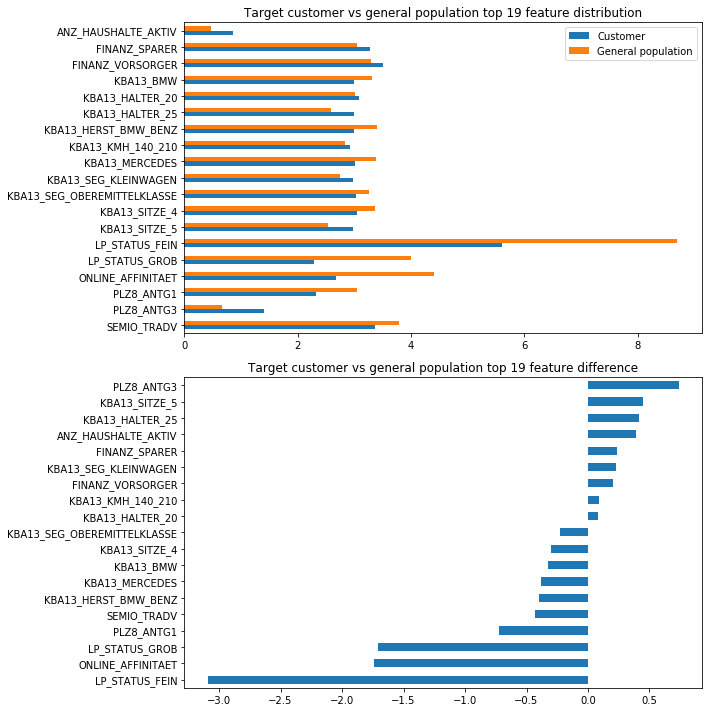

In [281]:
# find mean value to compare difference of each cluster
mean_target_cluster_customers = target_cluster_new_customers_df[TARGET_COLUMNS[-1::-1]].describe().loc['mean']
mean_target_cluster_azdias = target_cluster_new_azdias_df[TARGET_COLUMNS[-1::-1]].describe().loc['mean']

# draw distribution bar chart
mean_df = pd.concat([mean_target_cluster_customers, mean_target_cluster_azdias], axis=1)
mean_df.columns = ['Customer', 'General population']
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(211)
mean_df.plot.barh(ax=ax1)
plt.title('Target customer vs general population top {} feature distribution'.format(len(TARGET_COLUMNS)))

# draw difference bar chart
ax2 = plt.subplot(212)
(mean_df['Customer'] - mean_df['General population']).sort_values().plot.barh(ax=ax2)
plt.title('Target customer vs general population top {} feature difference'.format(len(TARGET_COLUMNS)))

plt.tight_layout()
plt.show()

### Conclusion

* From above we can somehow come out the customer face as: don't like on-line transaction, live in 6~10 family building, drive luxury car.
* We already include LNR information in every cluster. Compony can send advertisement to most customer like general population.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [199]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/fc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [200]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


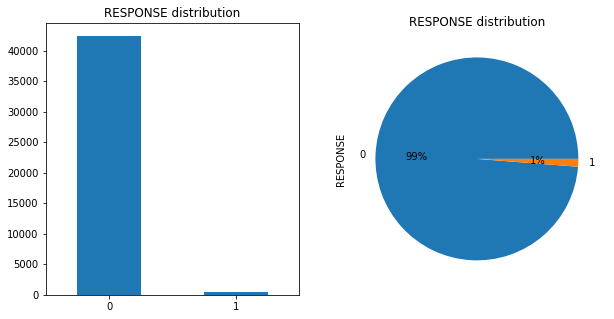

In [201]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(121)
mailout_train['RESPONSE'].value_counts().plot.bar(rot=0, ax=ax1)
plt.title('RESPONSE distribution')

ax1 = plt.subplot(122)
mailout_train['RESPONSE'].value_counts().plot.pie(autopct='%1.f%%')
plt.title('RESPONSE distribution')

plt.show()

#### What we want to do here ...

* Data Cleaning
    - Perform data preprocessing with `clean_data` created in Part 0.
* Metrices Selection
    - Select the best metrices to measure performance.
* Model Selection
    - Select the best machine learning algorithm for the dataset.
* XGBoost Tuning
    - Fine-tune XGBoost hyperparameters.

### Data Cleaning
Perform data preprocessing with `clean_data` created in Part 0.

In [202]:
new_mailout_train_df = clean_data(mailout_train.copy())

mix_cat...
drop...
log_transform...


/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log1p
  app.launch_new_instance()
/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


cap outlier...


/home/fc/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


cover...
ANZ_PERSONEN in general population have min value: 0.6931471805599453 larger than sample: 0.0 -> drop
ANZ_PERSONEN in general population have max value: 1.6094379124341003 smaller than sample: 1.791759469228055 -> drop


/home/fc/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


fillna...


/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


onehot...
clean_data successfully :)


In [203]:
new_mailout_train_df.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A_8.0,VK_DHT4A_9.0,VK_DHT4A_10.0,VK_DHT4A_11.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
LNR,,,,,,,,,,,,,,,,,,,,,
1763,1.0,4,2,2.772589,0.0,0.0,0.693147,2.639057,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
1771,4.0,3,2,0.693147,0.0,0.0,1.098612,0.693147,0.0,2.0,...,0,0,0,0,1,0,0,0,0,0
1776,1.0,4,1,0.693147,0.0,0.0,1.098612,0.693147,0.0,4.0,...,0,0,0,0,0,0,1,0,0,0
1460,1.0,4,2,1.609438,0.0,0.0,1.098612,1.609438,0.0,4.0,...,1,0,0,0,0,0,1,0,0,0
1783,1.0,3,1,3.295837,0.0,0.0,0.693147,3.218876,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0


In [204]:
new_mailout_train_df.to_pickle('new_mailout_train_df.pickle')

In [205]:
new_mailout_train_df = pd.read_pickle("new_mailout_train_df.pickle")

In [206]:
y_train = new_mailout_train_df['RESPONSE']
X_train = new_mailout_train_df.drop(['RESPONSE'], axis=1)

# scaling
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)

X_train.shape, y_train.shape

((42962, 410), (42962,))

### Metrices Selection
Select the best metrices to measure performance.

Since Kaggle use [AUC for the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) to evaluate model performance. So we use it as our metrices.

### Model Selection
Select the best machine learning algorithm for the dataset.

In [207]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
        
    axes : matplotlib.axes

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes == None:
        plt.figure()
    else:
        plt.axes = axes
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring='roc_auc', cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

__NOTE__: The `plot_learning_curve` function is used to draw learning curve. Which is inspired by [Plotting Learning Curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html).

We would like to use [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) to handle inbalance data.

In [208]:
# Initialize 5 StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, random_state=27)

In [209]:
clf_A = DecisionTreeClassifier(random_state=27)
clf_B = LinearSVC(random_state=27)
clf_C = AdaBoostRegressor(random_state=27)
clf_D = XGBRegressor(random_state=27)

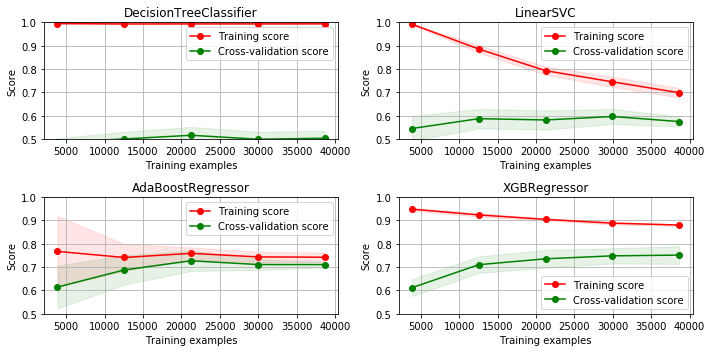

In [211]:
plt.figure(figsize=(10, 5))

# DecisionTreeClassifier
ax1 = plt.subplot(2,2,1)
plot_learning_curve(clf_A, 'DecisionTreeClassifier', X_train, y_train, axes=ax1, ylim=(0.5, 1), cv=cv, n_jobs=N_JOBS)

# LinearSVC
ax2 = plt.subplot(2,2,2)
plot_learning_curve(clf_B, 'LinearSVC', X_train, y_train, axes=ax2, ylim=(0.5, 1), cv=cv, n_jobs=N_JOBS)

#　AdaBoostRegressor
ax3 = plt.subplot(2,2,3)
plot_learning_curve(clf_C, 'AdaBoostRegressor', X_train, y_train, axes=ax3, ylim=(0.5, 1), cv=cv, n_jobs=N_JOBS)

# XGBRegressor
ax4 = plt.subplot(2,2,4)
plot_learning_curve(clf_D, 'XGBRegressor', X_train, y_train, axes=ax4, ylim=(0.5, 1), cv=cv, n_jobs=N_JOBS)

plt.tight_layout()
plt.show()

### XGBoost Tuning
Fine-tune XGBoost hyperparameters.

__NOTE__: The complete procedure for XGBoot tuning is inspired by [Complete Guide to Parameter Tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

#### Fix learning rate and number of estimators for tuning tree-based parameters

In [212]:
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, stratified=True, seed=27, verbose_eval=20)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values()[-20:]

    feat_imp.plot(kind='barh', title='Top 20 Feature Importance Score')
    plt.tight_layout()
    plt.show()

[0]	train-auc:0.760478+0.00476783	test-auc:0.753079+0.021462
[20]	train-auc:0.811904+0.0109538	test-auc:0.763993+0.0202809
[40]	train-auc:0.884264+0.0034646	test-auc:0.756888+0.0205218
[60]	train-auc:0.924534+0.00141521	test-auc:0.758681+0.016616

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.809832


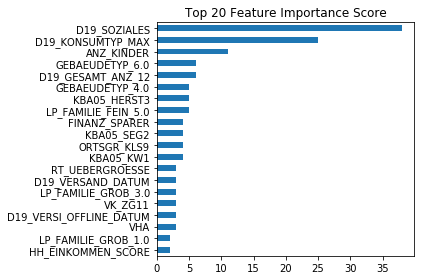

In [213]:
#Choose all predictors except target & IDcols
xgb_clf = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='binary:logistic',
     n_jobs=N_JOBS,
     scale_pos_weight=1,
     seed=27)
modelfit(xgb_clf, X_train, y_train)

#### Tune max_depth and min_child_weight####

In [214]:
param_test = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140, 
                                                  max_depth=5,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective='binary:logistic',
                                                  n_jobs=N_JOBS, 
                                                  scale_pos_weight=1, 
                                                  seed=27), 
     param_grid=param_test, scoring='roc_auc',n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

/home/fc/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


({'max_depth': 3, 'min_child_weight': 5}, 0.7572075116035069)

In [217]:
param_test = {
    'max_depth':range(1,4,1),
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140, 
                                                  max_depth=5,
                                                  min_child_weight=5,  # min_child_weight = 5
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective='binary:logistic',
                                                  n_jobs=N_JOBS, 
                                                  scale_pos_weight=1, 
                                                  seed=27), 
     param_grid=param_test, scoring='roc_auc', n_jobs=N_JOBS, iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 3}, 0.7572075116035069)

* max_depth: 3
* min_child_weight: 5

#### Tune gamma

In [218]:
param_test = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140, 
                                                  max_depth=3,  # max_depth = 3
                                                  min_child_weight=5,  # min_child_weight = 5 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective='binary:logistic',
                                                  n_jobs=N_JOBS, 
                                                  scale_pos_weight=1, 
                                                  seed=27), 
     param_grid=param_test, scoring='roc_auc', n_jobs=N_JOBS, iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'gamma': 0.2}, 0.7631733146017463)

* max_depth: 3
* min_child_weight: 5
* gamma: 0.2

[0]	train-auc:0.759385+0.00511119	test-auc:0.753227+0.021607
[20]	train-auc:0.778492+0.00846384	test-auc:0.763195+0.0224661
[40]	train-auc:0.810568+0.0046646	test-auc:0.762412+0.0264204
[60]	train-auc:0.836118+0.00590281	test-auc:0.760124+0.0223336
[80]	train-auc:0.859655+0.00454434	test-auc:0.762232+0.0203651

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.809308


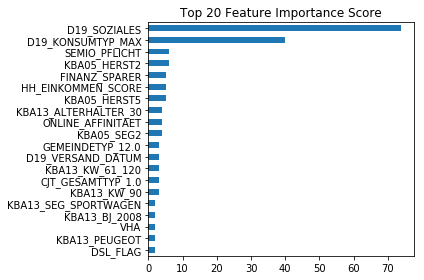

In [219]:
xgb_clf = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=3,
     min_child_weight=5,
     gamma=0.2,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='binary:logistic',
     n_jobs=N_JOBS,
     scale_pos_weight=1,
     seed=27)
modelfit(xgb_clf, X_train, y_train)

#### Tune subsample and colsample_bytree

In [221]:
param_test = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140, 
                                                  max_depth=3,  # max_depth = 3
                                                  min_child_weight=5,  # min_child_weight = 5 
                                                  gamma=0.2,  # gamma = 0.2
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective='binary:logistic',
                                                  n_jobs=N_JOBS, 
                                                  scale_pos_weight=1, 
                                                  seed=27), 
     param_grid = param_test, scoring='roc_auc',n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.7631733146017463)

In [222]:
param_test = {
    'subsample':[i/100.0 for i in range(70,90,5)],
     'colsample_bytree':[i/100.0 for i in range(70,90,5)]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140, 
                                                  max_depth=3,  # max_depth = 3
                                                  min_child_weight=5,  # min_child_weight = 5 
                                                  gamma=0.2,  # gamma = 0.2
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective='binary:logistic',
                                                  n_jobs=N_JOBS, 
                                                  scale_pos_weight=1, 
                                                  seed=27), 
     param_grid=param_test, scoring='roc_auc',n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.7631733146017463)

* max_depth: 3
* min_child_weight: 5
* gamma: 0.2
* subsample': 0.8
* colsample_bytree: 0.8

#### Tuning Regularization Parameters

In [223]:
param_test = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140, 
                                                  max_depth=3,  # max_depth = 3
                                                  min_child_weight=5,  # min_child_weight = 5 
                                                  gamma=0.2,  # gamma = 0.2
                                                  subsample=0.8,  # subsample': 0.8
                                                  colsample_bytree=0.8,  # colsample_bytree = 0.8
                                                  objective='binary:logistic',
                                                  n_jobs=N_JOBS, 
                                                  scale_pos_weight=1, 
                                                  seed=27), 
     param_grid=param_test, scoring='roc_auc',n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'reg_alpha': 1e-05}, 0.7631733146017463)

In [224]:
param_test = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140, 
                                                  max_depth=3,  # max_depth = 3
                                                  min_child_weight=5,  # min_child_weight = 5 
                                                  gamma=0.2,  # gamma = 0.2
                                                  subsample=0.8,  # subsample': 0.8
                                                  colsample_bytree=0.8,  # colsample_bytree = 0.8
                                                  objective='binary:logistic',
                                                  n_jobs=N_JOBS, 
                                                  scale_pos_weight=1, 
                                                  seed=27), 
     param_grid=param_test, scoring='roc_auc', n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'reg_alpha': 0}, 0.7631733146017463)

* max_depth: 3
* min_child_weight: 5
* gamma: 0.2
* subsample': 0.8
* colsample_bytree: 0.8
* reg_alpha: 0

[0]	train-auc:0.759385+0.00511119	test-auc:0.753227+0.021607
[20]	train-auc:0.778492+0.00846384	test-auc:0.763195+0.0224661
[40]	train-auc:0.810568+0.0046646	test-auc:0.762412+0.0264204
[60]	train-auc:0.836118+0.00590281	test-auc:0.760124+0.0223336
[80]	train-auc:0.859655+0.00454434	test-auc:0.762232+0.0203651

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.809308


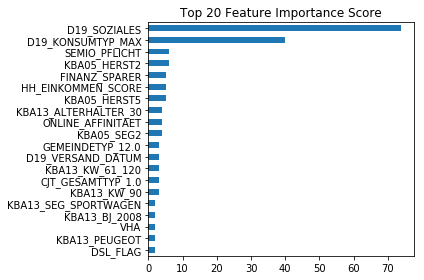

In [225]:
xgb_clf = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=3,
     min_child_weight=5,
     gamma=0.2,
     subsample=0.8,
     colsample_bytree=0.8,
     reg_alpha=0,
     objective= 'binary:logistic',
     n_jobs=N_JOBS,
     scale_pos_weight=1,
     seed=27)
modelfit(xgb_clf, X_train, y_train)

#### Reducing Learning Rate

[0]	train-auc:0.759385+0.00511119	test-auc:0.753227+0.021607
[20]	train-auc:0.780628+0.00690113	test-auc:0.763209+0.0222421
[40]	train-auc:0.81343+0.00460679	test-auc:0.764663+0.0248708
[60]	train-auc:0.844003+0.00600585	test-auc:0.76197+0.0196697
[80]	train-auc:0.867248+0.00521358	test-auc:0.760616+0.0206107

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.814929


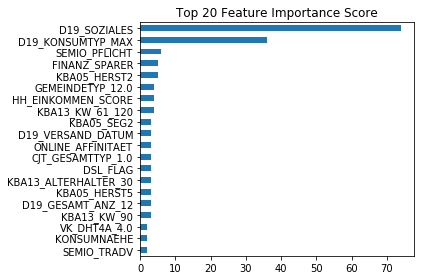

In [231]:
xgb_clf = XGBClassifier(
     learning_rate =0.11,
     n_estimators=5000,
     max_depth=3,
     min_child_weight=5,
     gamma=0.2,
     subsample=0.8,
     colsample_bytree=0.8,
     reg_alpha=0,
     objective= 'binary:logistic',
     n_jobs=N_JOBS,
     scale_pos_weight=1,
     seed=27)
modelfit(xgb_clf, X_train, y_train)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [232]:
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/home/fc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [233]:
mailout_test.shape

(42833, 366)

In [234]:
# data preprocessing
new_mailout_test_df = clean_data(mailout_test.copy())

mix_cat...
drop...
log_transform...


/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log1p
  app.launch_new_instance()
/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


cap outlier...


/home/fc/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


cover...
ANZ_PERSONEN in general population have min value: 0.6931471805599453 larger than sample: 0.0 -> drop
ANZ_PERSONEN in general population have max value: 1.6094379124341003 smaller than sample: 1.791759469228055 -> drop


/home/fc/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


fillna...


/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


onehot...
clean_data successfully :)


In [235]:
new_mailout_test_df.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A_8.0,VK_DHT4A_9.0,VK_DHT4A_10.0,VK_DHT4A_11.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
LNR,,,,,,,,,,,,,,,,,,,,,
1754,1.0,4,1,1.098612,0.0,0.0,1.098612,1.098612,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
1770,1.0,4,1,3.044522,0.0,0.0,0.693147,3.091042,0.0,4.0,...,0,0,0,0,0,0,1,0,0,0
1465,9.0,4,2,1.098612,0.0,0.0,1.609438,1.098612,0.0,4.0,...,0,1,0,0,0,0,1,0,0,0
1470,7.0,4,2,0.693147,0.0,0.0,1.098612,0.693147,0.0,4.0,...,0,0,0,0,0,0,1,0,0,0
1478,1.0,4,2,0.693147,0.0,0.0,1.609438,0.693147,0.0,3.0,...,0,0,0,0,0,0,0,1,0,0


In [236]:
new_mailout_test_df.to_pickle('new_mailout_test_df.pickle')

In [237]:
new_mailout_test_df = pd.read_pickle("new_mailout_test_df.pickle")

In [238]:
X_test = new_mailout_test_df

# scaling
X_test = pd.DataFrame(scaler.fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

X_test.shape

(42833, 410)

In [239]:
y_predict = xgb_clf.predict_proba(X_test)
y_predict[:,1]

array([0.03274399, 0.03479688, 0.00478128, ..., 0.03002056, 0.02527574,
       0.02580373], dtype=float32)

In [240]:
pd.DataFrame(index=mailout_test.LNR, data=y_predict[:, 1], columns=['RESPONSE']).to_csv("kaggle_predictions.txt")

In [241]:
pd.read_csv('kaggle_predictions.txt').head()

,LNR,RESPONSE
0,1754,0.032744
1,1770,0.034797
2,1465,0.004781
3,1470,0.006117
4,1478,0.006864


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Arvato\ Project\ Workbook.ipynb'])